**Name:** Henrique Parede de Souza

**Student ID:** 260497

Transform this notebook into a technical report on experiments using a **VAE (Variational Autoencoder)** architecture.

* Add comments to the different code blocks, explaining the purpose of each one.
* Explain how the **latent space** is constructed. Show different results for various configurations.
* Change the model's training parameters.
* Propose ways to evaluate the quality of the generated samples.

### Attr2Font

* **Github:** [https://github.com/hologerry/Attr2Font](https://github.com/hologerry/Attr2Font)
* **Dataset:** [https://drive.google.com/file/d/1TTqAklfsAp6KOPxCVl2jktH8kN4lEmI_/view](https://drive.google.com/file/d/1TTqAklfsAp6KOPxCVl2jktH8kN4lEmI_/view)

# Introdução

O presente trabalho tem como objetivo explorar o uso de Variational Autoencoders (VAEs) para geração de imagens de fontes textuais, com base nos datos sintéticos gerados pelo modelo Attr2Font.



### Arquitetura Base dos VAEs

Autoencoders consistem em uma arquitetura de redes neurais treinada codificar a entrada em uma representação latente comprimida, e então decodificá-la de forma a tentar reconstruir a entrada da maneira mais verossímil possível. Desta forma, a representação latente do espaço de entrada corresponde a uma compressão que tenta manter as representações significativas da entrada.

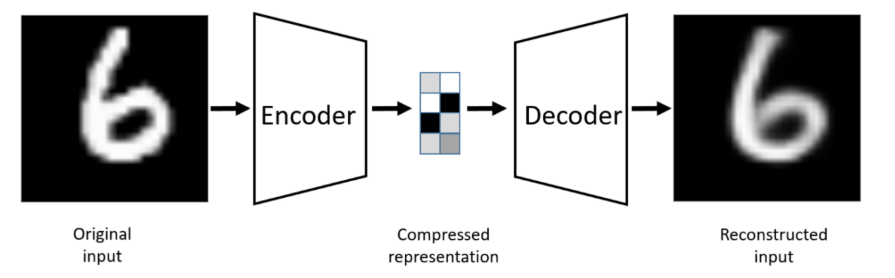

Os Variational Autoencoders (VAEs) correspondem a uma evolução dos autoencoders tradicionais, consistindo de modelos generativos que tentam descrever a geração de dados por meio de distribuições de probabilidade (no geral Gaussianas), aprendendo-as no espaço latente por meio de uma camada adicional do codificador capaz de aprender as característcas da distribuição.

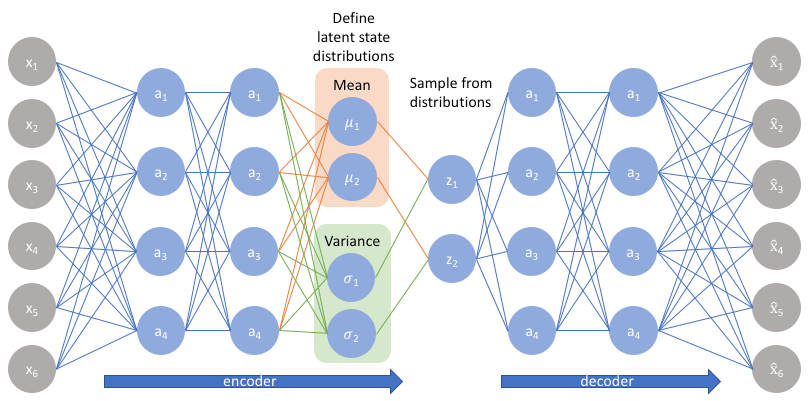

### Attr2Font



O Attr2Font é um modelo de síntese de fontes tipográficas condicionada a atributos visuais, permitindo criar letras com novos estilos a partir de valores definidos para atributos de fonte. Neste trabalho, utilizaremos as imagens geradas pelo modelo como dataset para treinamento da nossa VAE, desconsiderando, portanto, os atributos de estilo que geraram cada uma das imagens.

Referências e fontes das imagens:

- [Autoencoders](https://arxiv.org/pdf/2003.05991) (Bank et al., 2020)

- [Variational autoencoders](https://www.jeremyjordan.me/variational-autoencoders/) (Jeremy Jordan, 2018)

- [Attribute2Font: Creating Fonts You Want From Attributes](https://arxiv.org/abs/2005.07865) (Wang et al., 2020)

# Metodologia

Para possibilitar o entendimento de cada elemento da arquitetura e do treinamento das VAEs, dividiremos os estudos da seguinte forma:

- **Implementação do modelo base**
  - Uso do código já fornecido para treinamento do modelo que servirá como referencial para as análises dos resultados.
- **Exploração do espaço latente**
  - O espaço latente é onde o VAE aprende uma representação compacta da entrada.
  - Exploração de diferentes dimensionalidades (e.g., z = 2, 16, 64, 128).
  - Redução ao método de análise de componentes principais (PCA), em especial para z = 2.
- **Proposta de modelos com parâmentros modificados**
  - Configurações a serem testadas
    - Adição de camadas convolucionais (ConvVAE)
    - Taxa de aprendizado: 1e-3, 1e-4.
    - Early Stop
    - Regularização: Beta-VAE.
- **Métricas para avaliação dos resultados**
  - Qualitativas:
    - Visualizar amostras geradas.
    - Interpolação no espaço latente (entre duas imagens).
  - Quantitativas:
    - Reconstruction Error: Mede a fidelidade da imagem reconstruída em relação à original.
    - Mean Squared Error (MSE): Calcula a média dos quadrados das diferenças entre os pixels das imagens original e reconstruída. Um valor menor indica maior similaridade e melhor reconstrução.
    - Structural Similarity Index (SSIM): Mede a similaridade entre duas imagens considerando luminância, contraste e estrutura. Um valor mais próximo de 1 indica maior similaridade perceptiva.

In [ ]:
!pip install torchmetrics[image]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 49.9 MB/s eta 0:00:00


### Importing Libs

In [ ]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets,transforms
from torchvision.utils import save_image
from tqdm.notebook import tqdm
import os
import shutil
import random
random.seed(5)
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import torchmetrics
import torchvision.transforms as T
from skimage.metrics import structural_similarity as ssim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, TensorDataset

### Google Drive

In [ ]:
## Connects with google if necessary
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir -p /content/drive/MyDrive/IA376/VAE

In [ ]:
results_path = '/content/drive/MyDrive/IA376/VAE'
if os.path.exists(results_path): print(f"The directory {results_path} exists.")
else:                         print(f"The directory {results_path} does not exist.")

The directory /content/drive/MyDrive/IA376/VAE exists.


# Funções e Classes Importantes

In [ ]:
def show_img(img):
    img = img.permute(1, 2, 0)
    if img.shape[2]==1:
        img = img.view(img.shape[0], img.shape[1])
    plt.title(f'Image has size {img.cpu().numpy().shape}')
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.show()

### VAE implementation

In [ ]:
class VAE(nn.Module):
    def __init__(self, z):
        super(VAE, self).__init__()

        self.z = z # Latent space dimensions

        #ENCODER
        self.fc1 = nn.Linear(50*50,1000) # Fully connected layer, transforma a entrada 50x50 em 1000 features
        self.fc21 = nn.Linear(1000,z)   # Camada para gerar a média da distribuição latente
        self.fc22 = nn.Linear(1000,z)   # Camada para gerar o log da variância da distribuição latente

        #DECODER
        self.fc3 = nn.Linear(z,1000)     # Reconstroi o espaço original
        self.fc4 = nn.Linear(1000,50*50) # Reconstroi imagem

    def encode(self, x): # Codifica a entrada para o espaço latente
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar): # Aplica reparameterization trick
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z): # Reconstrói a entrada a partir de z
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x): # encode -> reparametrize -> decode
        mu, logvar = self.encode(x.view(-1, 50*50))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### Loss Function Implementation

In [ ]:
def loss_function(recon_x, x, mu, logvar):

    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 50*50), reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

### Loops de Treinamento e Avaliação

In [ ]:
def evaluate(evaluate_data, experiment='base'):


    val_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(evaluate_data):

            data=data.to(device)
            recon_batch,mu,logvar=model(data)
            val_loss += loss_function(recon_batch,data,mu,logvar).item()


            if i == 0:
                n = min(data.size(0), 16)
                comparison = torch.cat([data[:n],
                                        recon_batch.view(batch_size, 1, 50, 50)[:n]])
                save_image(comparison.cpu(),
                           f'{results_path}/results/{experiment}/reconstruction_' + str(epoch) + '.pdf', nrow=n)

    val_loss /= len(evaluate_data.dataset)
    return val_loss


def sample_latent_space(epoch, batch_size=64, z=32, experiment='base'):
    with torch.no_grad():

        # how to sample from our latent space
        sample=torch.randn(batch_size,z).to(device)
        sample=model.decode(sample).cpu()

        save_image(sample.view(batch_size, 1, 50, 50),
                   f'{results_path}/results/{experiment}/sample_' + str(epoch) + '.pdf')

In [ ]:
def train(epoch, experiment='base'):

    model.train()
    train_loss = 0

    progress_bar = tqdm(train_loader, desc='Epoch {:03d}'.format(epoch), leave=False, disable=False)
    for data, _ in progress_bar:

        data=data.to(device)
        optimizer.zero_grad()
        recon_batch,mu,logvar=model(data)

        loss=loss_function(recon_batch,data,mu,logvar)
        loss.backward()
        train_loss+=loss.item()
        optimizer.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(data))})

    average_train_loss = train_loss / len(train_loader.dataset)
    tqdm.write('Training set loss (average, epoch {:03d}): {:.3f}'.format(epoch, average_train_loss))
    val_loss = evaluate(val_loader, experiment)
    tqdm.write('\t\t\t\t====> Validation set loss: {:.3f}'.format(val_loss))

    train_losses.append(average_train_loss)
    val_losses.append(val_loss)

    if epoch%300==0:
        torch.save(model.state_dict(), f'{results_path}/models/{experiment}/epoch_{epoch}.model')

# Importação e Tratamento do Dataset

### Data

In [ ]:
# Downloads the dataset
!gdown --id 1TTqAklfsAp6KOPxCVl2jktH8kN4lEmI_ -O /content/
!unzip /content/explor_all.zip

Streaming output truncated to the last 5000 lines.
  inflating: explor_all/image/DroidSerif-Bold/46.png  
  inflating: explor_all/image/DroidSerif-Bold/05.png  
  inflating: explor_all/image/DroidSerif-Bold/03.png  
  inflating: explor_all/image/DroidSerif-Bold/37.png  
  inflating: explor_all/image/DroidSerif-Bold/15.png  
  inflating: explor_all/image/DroidSerif-Bold/29.png  
  inflating: explor_all/image/DroidSerif-Bold/19.png  
  inflating: explor_all/image/DroidSerif-Bold/39.png  
  inflating: explor_all/image/DroidSerif-Bold/56.png  
  inflating: explor_all/image/DroidSerif-Bold/58.png  
  inflating: explor_all/image/DroidSerif-Bold/42.png  
  inflating: explor_all/image/DroidSerif-Bold/38.png  
 extracting: explor_all/image/DroidSerif-Bold/52.png  
  inflating: explor_all/image/DroidSerif-Bold/34.png  
  inflating: explor_all/image/DroidSerif-Bold/61.png  
  inflating: explor_all/image/DroidSerif-Bold/48.png  
  inflating: explor_all/image/DroidSerif-Bold/53.png  
  inflating: e

In [ ]:
# Cria os diretórios de interesse:
!mkdir /content/data/
!mkdir /content/drive/MyDrive/IA376/VAE/results/
!mkdir /content/drive/MyDrive/IA376/VAE/models/
!mv /content/explor_all/image /content/data/Fonts
!rm -rf /content/explor_all

In [ ]:
epochs=5
batch_size=64
torch.manual_seed(17)

In [ ]:
path= '/content/data/Fonts'
train_path = '/content/data/trainFonts'
val_path = '/content/data/valFonts'

In [ ]:
transforms_all = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=50),
    transforms.ToTensor()
])

dummy_batch = torch.utils.data.DataLoader(
    datasets.ImageFolder(path,transform=transforms.ToTensor()),
    batch_size=1, shuffle=True
)

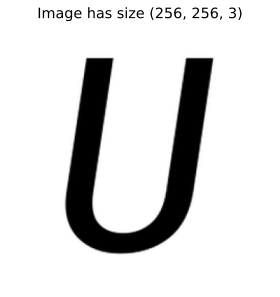

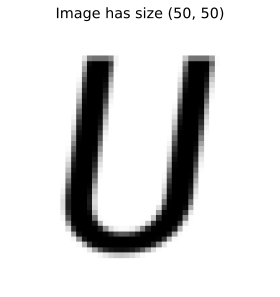

In [ ]:
for batch in dummy_batch:
  original_image=batch[0][0]
  show_img(original_image)
  show_img(transforms_all(transforms.ToPILImage()(original_image)))
  break

### Splitting Data into Training and Validation Sets

In [ ]:
folders=os.listdir(path)
print(len(folders))

# shutil.rmtree('/content/drive/MyDrive/Corpora/trainFonts')
# shutil.rmtree('/content/drive/MyDrive/Corpora/valFonts')

os.mkdir(train_path) #'../content/data/trainFonts'
os.mkdir(val_path)   #'../content/data/valFonts'


# Podemos limitar em num_folders a quantidade total de pasta que iremos trabalhar, no total temos 1116.
num_folders = 134
count_folders = 1
for folder in tqdm(folders):
    if count_folders <= num_folders:
      print(folder)
      os.mkdir(f'{train_path}/{folder}')
      os.mkdir(f'{val_path}/{folder}')
      images = os.listdir(f'{path}/{folder}')
      random.shuffle(images)
      for image in images[:20]:
        shutil.copy(f'{path}/{folder}/{image}',
                  f'{val_path}/{folder}/{image}')
      for image in images[20:]:
        shutil.copy(f'{path}/{folder}/{image}',
                  f'{train_path}/{folder}/{image}')
    count_folders += 1

1116


  0%|          | 0/1116 [00:00<?, ?it/s]

Simonetta-Black
Alegreya-Regular
Vidaloka-Regular
Oxygen-Regular
BubblerOne-Regular
PT_Sans-Narrow-Web-Regular
Condiment-Regular
PT_Sans-Caption-Web-Bold
Overlock-Black
VastShadow-Regular
Roboto-Bold
Sansation-Bold
ArchitectsDaughter
OpenSans-Light
Telex-Regular
TitilliumWeb-Black
Lora-Bold
CabinSketch-Regular
Neuton-ExtraBold
Arvo-Bold
NovaScript
OverlockSC-Regular
Roboto-BlackItalic
Unkempt-Bold
Volkhov-Bold
Raleway-SemiBold
IndieFlower
IMFeDPsc28P
Stoke-Light
SourceCodePro-Semibold
Rochester-Regular
KaushanScript-Regular
Carme-Regular
Ubuntu-Bold
Amiri-Bold
ArchivoBlack-Regular
JosefinSans-BoldItalic
LoveYaLikeASister
StalinistOne-Regular
Zeyada
Rye-Regular
StardosStencil-Regular
Fenix-Regular
WendyOne-Regular
Merienda-Regular
Rationale-Regular
Enriqueta-Regular
Lekton-Italic
Quicksand-Light
AveriaSerifLibre-Regular
Spinnaker-Regular
Julee-Regular
Exo-ExtraLightItalic
Share-BoldItalicOSF
OFLGoudyStMTT-Italic
Signika-Bold
ArchivoNarrow-Bold
ExpletusSans-Bold
Economica-Regular
Trochut

In [ ]:
print(len(os.listdir(train_path)))
print(len(os.listdir(val_path)))

134
134


### Building dataloader

In [ ]:
transforms_set = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=50),
    transforms.ToTensor()
])

train_loader=torch.utils.data.DataLoader(
    datasets.ImageFolder(f'{train_path}',transform=transforms_set),
    batch_size=batch_size, shuffle=True
)

val_loader=torch.utils.data.DataLoader(
    datasets.ImageFolder(f'{val_path}',transform=transforms_set),
    batch_size=batch_size, shuffle=True
)

# Modelo Base

In [ ]:
!mkdir /content/drive/MyDrive/IA376/VAE/models/base/
!mkdir /content/drive/MyDrive/IA376/VAE/results/base/

### Building the Model

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=VAE(z=32).to(device)
print('Device: ',device)
model=VAE(z=32).to(device)
optimizer=optim.Adam(model.parameters(),lr=1e-3)

Device:  cuda


### Training

In [ ]:
epochs = 200

train_losses,val_losses=[],[]

for epoch in range(1,epochs+1):
  train(epoch, 'base')
  sample_latent_space(epoch, batch_size=64, z=model.z, experiment='base')

np.savetxt(f'{results_path}/models/base/training_losses.txt', np.array(train_losses), delimiter='\n')
np.savetxt(f'{results_path}/models/base/validation_losses.txt', np.array(val_losses), delimiter='\n')
torch.save(model.state_dict(), f"{results_path}/models/base/vae.pth")



Epoch 001:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 001): 671.893
				====> Validation set loss: 549.602


Epoch 002:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 002): 493.488
				====> Validation set loss: 463.559


Epoch 003:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 003): 428.938
				====> Validation set loss: 411.874


Epoch 004:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 004): 389.041
				====> Validation set loss: 385.390


Epoch 005:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 005): 366.795
				====> Validation set loss: 362.916


Epoch 006:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 006): 352.964
				====> Validation set loss: 358.954


Epoch 007:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 007): 342.671
				====> Validation set loss: 339.590


Epoch 008:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 008): 331.103
				====> Validation set loss: 337.824


Epoch 009:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 009): 321.425
				====> Validation set loss: 325.045


Epoch 010:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 010): 312.965
				====> Validation set loss: 318.952


Epoch 011:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 011): 306.702
				====> Validation set loss: 312.707


Epoch 012:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 012): 302.441
				====> Validation set loss: 310.229


Epoch 013:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 013): 296.178
				====> Validation set loss: 306.775


Epoch 014:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 014): 294.402
				====> Validation set loss: 303.688


Epoch 015:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 015): 289.058
				====> Validation set loss: 299.009


Epoch 016:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 016): 284.877
				====> Validation set loss: 296.052


Epoch 017:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 017): 281.664
				====> Validation set loss: 296.752


Epoch 018:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 018): 278.867
				====> Validation set loss: 297.432


Epoch 019:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 019): 277.580
				====> Validation set loss: 294.433


Epoch 020:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 020): 274.698
				====> Validation set loss: 290.792


Epoch 021:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 021): 271.929
				====> Validation set loss: 287.098


Epoch 022:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 022): 270.037
				====> Validation set loss: 285.184


Epoch 023:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 023): 269.014
				====> Validation set loss: 288.697


Epoch 024:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 024): 268.287
				====> Validation set loss: 285.284


Epoch 025:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 025): 265.073
				====> Validation set loss: 285.064


Epoch 026:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 026): 263.999
				====> Validation set loss: 284.328


Epoch 027:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 027): 262.911
				====> Validation set loss: 282.122


Epoch 028:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 028): 259.837
				====> Validation set loss: 280.572


Epoch 029:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 029): 260.166
				====> Validation set loss: 281.062


Epoch 030:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 030): 259.636
				====> Validation set loss: 279.549


Epoch 031:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 031): 257.093
				====> Validation set loss: 278.367


Epoch 032:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 032): 256.534
				====> Validation set loss: 278.576


Epoch 033:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 033): 256.174
				====> Validation set loss: 277.334


Epoch 034:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 034): 253.203
				====> Validation set loss: 276.565


Epoch 035:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 035): 252.845
				====> Validation set loss: 276.189


Epoch 036:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 036): 252.063
				====> Validation set loss: 276.397


Epoch 037:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 037): 251.815
				====> Validation set loss: 275.562


Epoch 038:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 038): 249.941
				====> Validation set loss: 271.528


Epoch 039:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 039): 249.677
				====> Validation set loss: 271.964


Epoch 040:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 040): 248.217
				====> Validation set loss: 272.786


Epoch 041:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 041): 247.982
				====> Validation set loss: 275.065


Epoch 042:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 042): 247.459
				====> Validation set loss: 271.112


Epoch 043:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 043): 246.575
				====> Validation set loss: 272.516


Epoch 044:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 044): 246.191
				====> Validation set loss: 273.081


Epoch 045:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 045): 245.014
				====> Validation set loss: 271.137


Epoch 046:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 046): 244.891
				====> Validation set loss: 269.596


Epoch 047:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 047): 244.284
				====> Validation set loss: 274.171


Epoch 048:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 048): 243.241
				====> Validation set loss: 270.679


Epoch 049:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 049): 242.679
				====> Validation set loss: 270.114


Epoch 050:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 050): 242.568
				====> Validation set loss: 269.631


Epoch 051:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 051): 242.016
				====> Validation set loss: 270.134


Epoch 052:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 052): 241.338
				====> Validation set loss: 267.077


Epoch 053:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 053): 240.125
				====> Validation set loss: 270.420


Epoch 054:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 054): 239.411
				====> Validation set loss: 266.237


Epoch 055:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 055): 238.342
				====> Validation set loss: 270.464


Epoch 056:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 056): 238.880
				====> Validation set loss: 269.591


Epoch 057:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 057): 237.931
				====> Validation set loss: 270.454


Epoch 058:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 058): 237.873
				====> Validation set loss: 270.162


Epoch 059:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 059): 238.381
				====> Validation set loss: 268.172


Epoch 060:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 060): 237.664
				====> Validation set loss: 268.741


Epoch 061:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 061): 236.371
				====> Validation set loss: 268.243


Epoch 062:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 062): 236.561
				====> Validation set loss: 266.227


Epoch 063:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 063): 236.802
				====> Validation set loss: 268.886


Epoch 064:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 064): 235.621
				====> Validation set loss: 267.540


Epoch 065:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 065): 236.597
				====> Validation set loss: 266.896


Epoch 066:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 066): 234.727
				====> Validation set loss: 271.639


Epoch 067:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 067): 234.981
				====> Validation set loss: 267.491


Epoch 068:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 068): 233.384
				====> Validation set loss: 266.425


Epoch 069:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 069): 233.790
				====> Validation set loss: 268.532


Epoch 070:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 070): 233.682
				====> Validation set loss: 268.385


Epoch 071:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 071): 232.919
				====> Validation set loss: 267.317


Epoch 072:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 072): 232.789
				====> Validation set loss: 271.392


Epoch 073:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 073): 234.152
				====> Validation set loss: 267.187


Epoch 074:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 074): 232.848
				====> Validation set loss: 265.883


Epoch 075:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 075): 232.624
				====> Validation set loss: 268.803


Epoch 076:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 076): 232.847
				====> Validation set loss: 265.622


Epoch 077:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 077): 231.931
				====> Validation set loss: 266.953


Epoch 078:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 078): 230.927
				====> Validation set loss: 267.205


Epoch 079:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 079): 231.069
				====> Validation set loss: 269.317


Epoch 080:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 080): 230.919
				====> Validation set loss: 268.053


Epoch 081:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 081): 230.179
				====> Validation set loss: 267.940


Epoch 082:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 082): 230.109
				====> Validation set loss: 266.195


Epoch 083:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 083): 229.861
				====> Validation set loss: 267.965


Epoch 084:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 084): 230.458
				====> Validation set loss: 267.901


Epoch 085:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 085): 229.126
				====> Validation set loss: 266.998


Epoch 086:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 086): 230.620
				====> Validation set loss: 268.475


Epoch 087:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 087): 229.638
				====> Validation set loss: 270.356


Epoch 088:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 088): 229.698
				====> Validation set loss: 268.830


Epoch 089:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 089): 228.448
				====> Validation set loss: 266.741


Epoch 090:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 090): 228.463
				====> Validation set loss: 268.527


Epoch 091:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 091): 229.305
				====> Validation set loss: 267.697


Epoch 092:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 092): 228.543
				====> Validation set loss: 268.651


Epoch 093:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 093): 227.626
				====> Validation set loss: 269.186


Epoch 094:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 094): 228.043
				====> Validation set loss: 269.524


Epoch 095:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 095): 228.217
				====> Validation set loss: 269.034


Epoch 096:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 096): 227.534
				====> Validation set loss: 269.028


Epoch 097:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 097): 227.784
				====> Validation set loss: 270.917


Epoch 098:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 098): 228.059
				====> Validation set loss: 267.619


Epoch 099:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 099): 227.111
				====> Validation set loss: 270.478


Epoch 100:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 100): 227.938
				====> Validation set loss: 268.684


Epoch 101:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 101): 226.299
				====> Validation set loss: 269.095


Epoch 102:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 102): 225.987
				====> Validation set loss: 268.725


Epoch 103:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 103): 226.448
				====> Validation set loss: 269.724


Epoch 104:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 104): 225.756
				====> Validation set loss: 269.915


Epoch 105:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 105): 226.360
				====> Validation set loss: 268.518


Epoch 106:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 106): 225.518
				====> Validation set loss: 269.151


Epoch 107:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 107): 225.676
				====> Validation set loss: 267.180


Epoch 108:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 108): 224.866
				====> Validation set loss: 267.049


Epoch 109:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 109): 225.026
				====> Validation set loss: 268.881


Epoch 110:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 110): 224.514
				====> Validation set loss: 267.037


Epoch 111:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 111): 225.422
				====> Validation set loss: 268.487


Epoch 112:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 112): 225.139
				====> Validation set loss: 268.233


Epoch 113:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 113): 225.771
				====> Validation set loss: 267.200


Epoch 114:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 114): 224.153
				====> Validation set loss: 268.645


Epoch 115:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 115): 223.830
				====> Validation set loss: 268.920


Epoch 116:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 116): 224.983
				====> Validation set loss: 268.134


Epoch 117:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 117): 224.528
				====> Validation set loss: 271.315


Epoch 118:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 118): 224.045
				====> Validation set loss: 267.836


Epoch 119:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 119): 224.420
				====> Validation set loss: 267.925


Epoch 120:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 120): 223.885
				====> Validation set loss: 269.430


Epoch 121:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 121): 223.218
				====> Validation set loss: 268.237


Epoch 122:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 122): 223.872
				====> Validation set loss: 268.776


Epoch 123:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 123): 222.919
				====> Validation set loss: 266.059


Epoch 124:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 124): 222.905
				====> Validation set loss: 267.178


Epoch 125:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 125): 223.176
				====> Validation set loss: 271.306


Epoch 126:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 126): 223.900
				====> Validation set loss: 270.245


Epoch 127:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 127): 224.109
				====> Validation set loss: 270.908


Epoch 128:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 128): 222.534
				====> Validation set loss: 267.259


Epoch 129:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 129): 221.962
				====> Validation set loss: 269.184


Epoch 130:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 130): 223.162
				====> Validation set loss: 270.732


Epoch 131:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 131): 222.689
				====> Validation set loss: 269.445


Epoch 132:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 132): 222.142
				====> Validation set loss: 269.562


Epoch 133:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 133): 222.320
				====> Validation set loss: 272.115


Epoch 134:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 134): 222.588
				====> Validation set loss: 269.437


Epoch 135:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 135): 222.253
				====> Validation set loss: 268.161


Epoch 136:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 136): 222.000
				====> Validation set loss: 268.898


Epoch 137:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 137): 221.335
				====> Validation set loss: 269.413


Epoch 138:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 138): 221.210
				====> Validation set loss: 272.763


Epoch 139:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 139): 221.744
				====> Validation set loss: 272.779


Epoch 140:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 140): 221.828
				====> Validation set loss: 270.225


Epoch 141:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 141): 221.101
				====> Validation set loss: 270.384


Epoch 142:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 142): 221.538
				====> Validation set loss: 267.977


Epoch 143:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 143): 220.538
				====> Validation set loss: 267.523


Epoch 144:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 144): 220.851
				====> Validation set loss: 267.091


Epoch 145:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 145): 220.811
				====> Validation set loss: 267.574


Epoch 146:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 146): 220.570
				====> Validation set loss: 271.567


Epoch 147:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 147): 220.113
				====> Validation set loss: 267.716


Epoch 148:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 148): 220.620
				====> Validation set loss: 270.308


Epoch 149:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 149): 221.137
				====> Validation set loss: 270.718


Epoch 150:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 150): 220.434
				====> Validation set loss: 269.921


Epoch 151:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 151): 220.962
				====> Validation set loss: 269.789


Epoch 152:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 152): 220.281
				====> Validation set loss: 268.559


Epoch 153:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 153): 219.410
				====> Validation set loss: 270.729


Epoch 154:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 154): 219.884
				====> Validation set loss: 271.775


Epoch 155:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 155): 220.242
				====> Validation set loss: 272.171


Epoch 156:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 156): 219.879
				====> Validation set loss: 270.552


Epoch 157:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 157): 219.403
				====> Validation set loss: 274.868


Epoch 158:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 158): 220.030
				====> Validation set loss: 270.978


Epoch 159:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 159): 219.646
				====> Validation set loss: 272.510


Epoch 160:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 160): 219.510
				====> Validation set loss: 269.954


Epoch 161:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 161): 218.971
				====> Validation set loss: 270.755


Epoch 162:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 162): 219.751
				====> Validation set loss: 274.265


Epoch 163:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 163): 219.797
				====> Validation set loss: 270.361


Epoch 164:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 164): 218.987
				====> Validation set loss: 272.307


Epoch 165:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 165): 218.406
				====> Validation set loss: 270.801


Epoch 166:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 166): 218.987
				====> Validation set loss: 268.123


Epoch 167:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 167): 219.378
				====> Validation set loss: 274.124


Epoch 168:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 168): 217.636
				====> Validation set loss: 270.158


Epoch 169:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 169): 219.074
				====> Validation set loss: 272.027


Epoch 170:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 170): 218.376
				====> Validation set loss: 270.391


Epoch 171:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 171): 218.834
				====> Validation set loss: 270.789


Epoch 172:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 172): 218.228
				====> Validation set loss: 271.616


Epoch 173:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 173): 219.411
				====> Validation set loss: 270.873


Epoch 174:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 174): 218.602
				====> Validation set loss: 272.537


Epoch 175:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 175): 218.596
				====> Validation set loss: 271.555


Epoch 176:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 176): 217.731
				====> Validation set loss: 271.817


Epoch 177:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 177): 217.840
				====> Validation set loss: 272.090


Epoch 178:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 178): 218.246
				====> Validation set loss: 276.935


Epoch 179:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 179): 218.897
				====> Validation set loss: 271.817


Epoch 180:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 180): 217.385
				====> Validation set loss: 270.022


Epoch 181:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 181): 218.194
				====> Validation set loss: 270.063


Epoch 182:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 182): 218.019
				====> Validation set loss: 270.735


Epoch 183:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 183): 217.617
				====> Validation set loss: 273.186


Epoch 184:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 184): 217.877
				====> Validation set loss: 272.297


Epoch 185:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 185): 217.433
				====> Validation set loss: 274.883


Epoch 186:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 186): 218.330
				====> Validation set loss: 275.439


Epoch 187:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 187): 217.249
				====> Validation set loss: 271.446


Epoch 188:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 188): 216.953
				====> Validation set loss: 272.306


Epoch 189:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 189): 217.289
				====> Validation set loss: 276.159


Epoch 190:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 190): 216.609
				====> Validation set loss: 273.089


Epoch 191:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 191): 217.655
				====> Validation set loss: 273.413


Epoch 192:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 192): 216.642
				====> Validation set loss: 274.181


Epoch 193:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 193): 217.054
				====> Validation set loss: 273.980


Epoch 194:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 194): 216.491
				====> Validation set loss: 269.830


Epoch 195:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 195): 217.259
				====> Validation set loss: 271.072


Epoch 196:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 196): 216.374
				====> Validation set loss: 274.502


Epoch 197:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 197): 216.917
				====> Validation set loss: 273.182


Epoch 198:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 198): 216.129
				====> Validation set loss: 273.003


Epoch 199:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 199): 217.536
				====> Validation set loss: 275.426


Epoch 200:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 200): 216.902
				====> Validation set loss: 272.829


# Exploração do espaço latente

Para realizar os experimentos com a dimensão do espaço latente, serão treinados 3 modelos com dimensões latentes distintas: z = 2 (PCA), z = 32 e z = 64. Para viabilizar o treino, serão usadas 60 épocas para cada.

In [ ]:
!mkdir /content/drive/MyDrive/IA376/VAE/models/latent
!mkdir /content/drive/MyDrive/IA376/VAE/models/latent/z2
!mkdir /content/drive/MyDrive/IA376/VAE/models/latent/z32
!mkdir /content/drive/MyDrive/IA376/VAE/models/latent/z64

!mkdir /content/drive/MyDrive/IA376/VAE/results/latent
!mkdir /content/drive/MyDrive/IA376/VAE/results/latent/z2
!mkdir /content/drive/MyDrive/IA376/VAE/results/latent/z32
!mkdir /content/drive/MyDrive/IA376/VAE/results/latent/z64

Device:  cuda


Epoch 001:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 001): 688.475
				====> Validation set loss: 611.222


Epoch 002:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 002): 588.953
				====> Validation set loss: 583.488


Epoch 003:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 003): 570.125
				====> Validation set loss: 564.838


Epoch 004:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 004): 559.964
				====> Validation set loss: 560.342


Epoch 005:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 005): 554.481
				====> Validation set loss: 553.442


Epoch 006:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 006): 549.693
				====> Validation set loss: 552.775


Epoch 007:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 007): 546.953
				====> Validation set loss: 549.244


Epoch 008:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 008): 543.432
				====> Validation set loss: 547.299


Epoch 009:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 009): 541.057
				====> Validation set loss: 547.228


Epoch 010:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 010): 540.342
				====> Validation set loss: 545.496


Epoch 011:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 011): 538.667
				====> Validation set loss: 543.629


Epoch 012:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 012): 536.529
				====> Validation set loss: 542.360


Epoch 013:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 013): 537.693
				====> Validation set loss: 540.147


Epoch 014:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 014): 536.031
				====> Validation set loss: 542.561


Epoch 015:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 015): 534.213
				====> Validation set loss: 539.382


Epoch 016:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 016): 532.867
				====> Validation set loss: 537.921


Epoch 017:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 017): 531.135
				====> Validation set loss: 539.969


Epoch 018:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 018): 531.148
				====> Validation set loss: 536.460


Epoch 019:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 019): 531.159
				====> Validation set loss: 538.455


Epoch 020:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 020): 529.418
				====> Validation set loss: 542.207


Epoch 021:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 021): 526.421
				====> Validation set loss: 533.912


Epoch 022:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 022): 528.158
				====> Validation set loss: 536.413


Epoch 023:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 023): 527.445
				====> Validation set loss: 535.515


Epoch 024:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 024): 524.476
				====> Validation set loss: 531.982


Epoch 025:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 025): 523.033
				====> Validation set loss: 531.820


Epoch 026:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 026): 522.729
				====> Validation set loss: 529.408


Epoch 027:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 027): 523.020
				====> Validation set loss: 532.476


Epoch 028:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 028): 521.469
				====> Validation set loss: 533.791


Epoch 029:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 029): 519.563
				====> Validation set loss: 527.777


Epoch 030:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 030): 519.645
				====> Validation set loss: 532.301


Epoch 031:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 031): 517.985
				====> Validation set loss: 530.405


Epoch 032:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 032): 518.759
				====> Validation set loss: 529.728


Epoch 033:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 033): 516.894
				====> Validation set loss: 530.939


Epoch 034:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 034): 517.011
				====> Validation set loss: 529.258


Epoch 035:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 035): 515.727
				====> Validation set loss: 525.958


Epoch 036:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 036): 516.000
				====> Validation set loss: 526.385


Epoch 037:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 037): 513.941
				====> Validation set loss: 523.544


Epoch 038:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 038): 513.864
				====> Validation set loss: 525.492


Epoch 039:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 039): 513.761
				====> Validation set loss: 526.415


Epoch 040:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 040): 514.111
				====> Validation set loss: 527.522


Epoch 041:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 041): 514.381
				====> Validation set loss: 521.895


Epoch 042:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 042): 513.401
				====> Validation set loss: 522.975


Epoch 043:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 043): 512.375
				====> Validation set loss: 530.128


Epoch 044:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 044): 511.545
				====> Validation set loss: 525.804


Epoch 045:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 045): 511.191
				====> Validation set loss: 521.874


Epoch 046:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 046): 509.200
				====> Validation set loss: 522.672


Epoch 047:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 047): 510.139
				====> Validation set loss: 524.915


Epoch 048:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 048): 509.314
				====> Validation set loss: 522.567


Epoch 049:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 049): 507.651
				====> Validation set loss: 521.997


Epoch 050:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 050): 507.367
				====> Validation set loss: 521.247


Epoch 051:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 051): 508.503
				====> Validation set loss: 520.912


Epoch 052:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 052): 508.533
				====> Validation set loss: 521.807


Epoch 053:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 053): 507.256
				====> Validation set loss: 521.416


Epoch 054:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 054): 506.901
				====> Validation set loss: 521.628


Epoch 055:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 055): 507.304
				====> Validation set loss: 519.619


Epoch 056:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 056): 505.378
				====> Validation set loss: 518.248


Epoch 057:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 057): 505.516
				====> Validation set loss: 520.620


Epoch 058:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 058): 505.353
				====> Validation set loss: 519.339


Epoch 059:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 059): 504.511
				====> Validation set loss: 517.253


Epoch 060:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 060): 504.703
				====> Validation set loss: 518.911


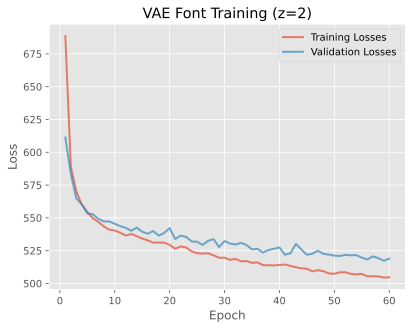

Device:  cuda


Epoch 001:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 001): 682.619
				====> Validation set loss: 541.379


Epoch 002:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 002): 494.023
				====> Validation set loss: 446.989


Epoch 003:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 003): 423.865
				====> Validation set loss: 411.027


Epoch 004:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 004): 388.110
				====> Validation set loss: 389.668


Epoch 005:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 005): 366.239
				====> Validation set loss: 361.266


Epoch 006:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 006): 350.116
				====> Validation set loss: 356.044


Epoch 007:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 007): 336.144
				====> Validation set loss: 336.336


Epoch 008:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 008): 325.089
				====> Validation set loss: 327.265


Epoch 009:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 009): 315.493
				====> Validation set loss: 320.205


Epoch 010:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 010): 310.828
				====> Validation set loss: 314.398


Epoch 011:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 011): 303.256
				====> Validation set loss: 311.264


Epoch 012:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 012): 297.659
				====> Validation set loss: 308.702


Epoch 013:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 013): 293.266
				====> Validation set loss: 304.464


Epoch 014:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 014): 289.869
				====> Validation set loss: 303.370


Epoch 015:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 015): 285.735
				====> Validation set loss: 299.604


Epoch 016:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 016): 283.474
				====> Validation set loss: 297.769


Epoch 017:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 017): 281.171
				====> Validation set loss: 295.343


Epoch 018:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 018): 279.646
				====> Validation set loss: 294.374


Epoch 019:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 019): 275.109
				====> Validation set loss: 292.744


Epoch 020:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 020): 272.828
				====> Validation set loss: 288.321


Epoch 021:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 021): 271.338
				====> Validation set loss: 287.608


Epoch 022:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 022): 268.821
				====> Validation set loss: 284.499


Epoch 023:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 023): 266.276
				====> Validation set loss: 282.297


Epoch 024:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 024): 264.423
				====> Validation set loss: 282.817


Epoch 025:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 025): 263.391
				====> Validation set loss: 283.478


Epoch 026:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 026): 261.919
				====> Validation set loss: 279.680


Epoch 027:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 027): 260.117
				====> Validation set loss: 279.358


Epoch 028:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 028): 259.271
				====> Validation set loss: 276.225


Epoch 029:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 029): 257.656
				====> Validation set loss: 276.507


Epoch 030:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 030): 255.439
				====> Validation set loss: 276.335


Epoch 031:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 031): 254.582
				====> Validation set loss: 276.024


Epoch 032:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 032): 253.889
				====> Validation set loss: 274.970


Epoch 033:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 033): 253.156
				====> Validation set loss: 276.516


Epoch 034:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 034): 251.738
				====> Validation set loss: 273.126


Epoch 035:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 035): 251.089
				====> Validation set loss: 273.557


Epoch 036:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 036): 249.843
				====> Validation set loss: 273.785


Epoch 037:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 037): 249.692
				====> Validation set loss: 273.286


Epoch 038:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 038): 248.300
				====> Validation set loss: 272.168


Epoch 039:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 039): 247.641
				====> Validation set loss: 272.125


Epoch 040:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 040): 247.046
				====> Validation set loss: 269.558


Epoch 041:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 041): 246.099
				====> Validation set loss: 271.460


Epoch 042:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 042): 246.330
				====> Validation set loss: 273.295


Epoch 043:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 043): 245.390
				====> Validation set loss: 275.533


Epoch 044:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 044): 244.596
				====> Validation set loss: 272.020


Epoch 045:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 045): 243.787
				====> Validation set loss: 270.227


Epoch 046:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 046): 242.611
				====> Validation set loss: 270.035


Epoch 047:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 047): 240.948
				====> Validation set loss: 268.844


Epoch 048:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 048): 241.860
				====> Validation set loss: 268.226


Epoch 049:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 049): 240.695
				====> Validation set loss: 268.791


Epoch 050:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 050): 240.263
				====> Validation set loss: 268.259


Epoch 051:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 051): 239.633
				====> Validation set loss: 269.348


Epoch 052:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 052): 239.196
				====> Validation set loss: 268.139


Epoch 053:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 053): 239.158
				====> Validation set loss: 267.353


Epoch 054:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 054): 238.349
				====> Validation set loss: 267.800


Epoch 055:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 055): 237.964
				====> Validation set loss: 268.491


Epoch 056:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 056): 237.307
				====> Validation set loss: 267.878


Epoch 057:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 057): 236.709
				====> Validation set loss: 269.196


Epoch 058:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 058): 236.595
				====> Validation set loss: 268.132


Epoch 059:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 059): 237.837
				====> Validation set loss: 268.516


Epoch 060:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 060): 235.710
				====> Validation set loss: 266.323


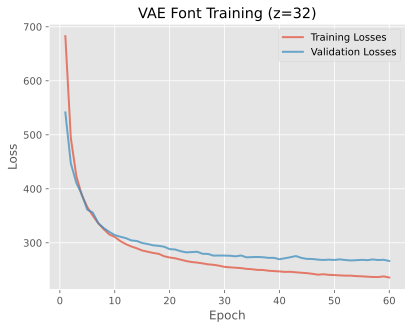

Device:  cuda


Epoch 001:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 001): 689.698
				====> Validation set loss: 555.079


Epoch 002:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 002): 528.036
				====> Validation set loss: 495.551


Epoch 003:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 003): 461.658
				====> Validation set loss: 447.095


Epoch 004:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 004): 422.251
				====> Validation set loss: 410.848


Epoch 005:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 005): 398.847
				====> Validation set loss: 396.361


Epoch 006:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 006): 382.044
				====> Validation set loss: 378.646


Epoch 007:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 007): 365.918
				====> Validation set loss: 365.710


Epoch 008:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 008): 355.435
				====> Validation set loss: 356.284


Epoch 009:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 009): 344.405
				====> Validation set loss: 348.486


Epoch 010:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 010): 335.869
				====> Validation set loss: 339.241


Epoch 011:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 011): 326.052
				====> Validation set loss: 331.377


Epoch 012:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 012): 320.994
				====> Validation set loss: 328.574


Epoch 013:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 013): 316.084
				====> Validation set loss: 322.764


Epoch 014:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 014): 310.049
				====> Validation set loss: 317.214


Epoch 015:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 015): 306.150
				====> Validation set loss: 318.227


Epoch 016:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 016): 302.513
				====> Validation set loss: 314.087


Epoch 017:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 017): 297.224
				====> Validation set loss: 307.983


Epoch 018:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 018): 293.314
				====> Validation set loss: 309.428


Epoch 019:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 019): 291.869
				====> Validation set loss: 305.230


Epoch 020:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 020): 287.714
				====> Validation set loss: 303.986


Epoch 021:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 021): 284.641
				====> Validation set loss: 299.033


Epoch 022:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 022): 282.093
				====> Validation set loss: 297.591


Epoch 023:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 023): 280.934
				====> Validation set loss: 295.896


Epoch 024:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 024): 278.269
				====> Validation set loss: 293.886


Epoch 025:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 025): 275.334
				====> Validation set loss: 290.506


Epoch 026:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 026): 273.602
				====> Validation set loss: 289.854


Epoch 027:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 027): 270.627
				====> Validation set loss: 288.209


Epoch 028:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 028): 269.243
				====> Validation set loss: 288.169


Epoch 029:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 029): 268.619
				====> Validation set loss: 286.881


Epoch 030:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 030): 265.840
				====> Validation set loss: 285.671


Epoch 031:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 031): 265.432
				====> Validation set loss: 283.680


Epoch 032:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 032): 263.539
				====> Validation set loss: 281.062


Epoch 033:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 033): 262.893
				====> Validation set loss: 285.074


Epoch 034:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 034): 259.753
				====> Validation set loss: 277.773


Epoch 035:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 035): 258.148
				====> Validation set loss: 276.283


Epoch 036:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 036): 256.215
				====> Validation set loss: 279.983


Epoch 037:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 037): 256.263
				====> Validation set loss: 276.187


Epoch 038:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 038): 255.912
				====> Validation set loss: 275.614


Epoch 039:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 039): 253.695
				====> Validation set loss: 276.554


Epoch 040:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 040): 253.230
				====> Validation set loss: 274.496


Epoch 041:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 041): 251.949
				====> Validation set loss: 274.816


Epoch 042:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 042): 250.931
				====> Validation set loss: 273.612


Epoch 043:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 043): 249.774
				====> Validation set loss: 275.343


Epoch 044:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 044): 250.498
				====> Validation set loss: 275.168


Epoch 045:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 045): 248.870
				====> Validation set loss: 274.160


Epoch 046:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 046): 248.630
				====> Validation set loss: 273.603


Epoch 047:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 047): 247.357
				====> Validation set loss: 271.911


Epoch 048:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 048): 247.467
				====> Validation set loss: 272.219


Epoch 049:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 049): 244.891
				====> Validation set loss: 269.010


Epoch 050:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 050): 244.763
				====> Validation set loss: 270.435


Epoch 051:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 051): 243.964
				====> Validation set loss: 269.580


Epoch 052:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 052): 244.127
				====> Validation set loss: 270.868


Epoch 053:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 053): 243.669
				====> Validation set loss: 272.914


Epoch 054:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 054): 243.345
				====> Validation set loss: 270.140


Epoch 055:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 055): 242.390
				====> Validation set loss: 269.959


Epoch 056:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 056): 240.996
				====> Validation set loss: 270.502


Epoch 057:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 057): 239.972
				====> Validation set loss: 268.881


Epoch 058:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 058): 239.951
				====> Validation set loss: 270.314


Epoch 059:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 059): 240.370
				====> Validation set loss: 270.887


Epoch 060:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 060): 239.770
				====> Validation set loss: 270.259


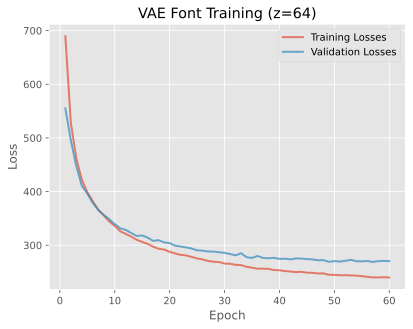

In [ ]:
epochs = 60

for z in [2, 32, 64]: # cada z proposto

  # Reinicia o modelo
  device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model=VAE(z=z).to(device)
  print('Device: ',device)
  model=VAE(z=z).to(device)
  optimizer=optim.Adam(model.parameters(),lr=1e-3)


  # treinamento
  train_losses,val_losses=[],[]

  for epoch in range(1,epochs+1):
    train(epoch, f'latent/z{str(z)}')
    sample_latent_space(epoch, batch_size=64, z=z, experiment=f'latent/z{str(z)}')

  # salva resultados
  np.savetxt(f'{results_path}/models/latent/z{str(z)}/training_losses.txt', np.array(train_losses), delimiter='\n')
  np.savetxt(f'{results_path}/models/latent/z{str(z)}/validation_losses.txt', np.array(val_losses), delimiter='\n')
  torch.save(model.state_dict(), f"{results_path}/models/latent/z{str(z)}/vae.pth")

  # plots
  train_losses=np.loadtxt(f'{results_path}/models/latent/z{str(z)}/training_losses.txt')
  val_losses=np.loadtxt(f'{results_path}/models/latent/z{str(z)}/validation_losses.txt')

  plt.plot(
      range(1,len(train_losses)+1),
      train_losses,
      label='Training Losses',
      linewidth=2,
      alpha=0.7
  )
  plt.plot(
      range(1,len(val_losses)+1),
      val_losses,
      label='Validation Losses',
      linewidth=2,
      alpha=0.7
  )

  plt.title(f'VAE Font Training (z={str(z)})')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  pass

# Conv VAE

In [ ]:
!mkdir /content/drive/MyDrive/IA376/VAE/models/conv
!mkdir /content/drive/MyDrive/IA376/VAE/results/conv

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, z, input_channels=1):
        super(ConvVAE, self).__init__()

        self.z = z

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(4),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(128 * 4 * 4, z)
        self.fc_logvar = nn.Linear(128 * 4 * 4, z)
        self.fc_decoder = nn.Linear(z, 128 * 4 * 4)

        # decoder com upsampling final
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, 2, 1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, 2, 1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channels, 3, 2, 1, output_padding=1),
            nn.Upsample(size=50, mode='bilinear'),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def decode(self, z):
        h = F.relu(self.fc_decoder(z))
        h = h.view(-1, 128, 4, 4)
        return self.decoder(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
def ConvVAE_loss_function(recon_x, x, mu, logvar):
    if recon_x.shape != x.shape: # garantir que as dimensões batem
        recon_x = F.interpolate(recon_x, size=x.shape[2:], mode='bilinear', align_corners=False)

    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
def ConvVAE_evaluate(evaluate_data, experiment='base'):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(evaluate_data):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            val_loss += ConvVAE_loss_function(recon_batch, data, mu, logvar).item()

            if i == 0:
                n = min(data.size(0), 16)
                comparison = torch.cat([data[:n], recon_batch[:n]])
                save_image(comparison.cpu(), f'{results_path}/results/{experiment}/reconstruction_' + str(epoch) + '.pdf', nrow=n)

    val_loss /= len(evaluate_data.dataset)
    return val_loss

def ConvVAE_sample_latent_space(epoch, batch_size=64, z=32, experiment='base'):
    model.eval()
    with torch.no_grad():
        sample = torch.randn(batch_size, z).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(batch_size, 1, 50, 50), f'{results_path}/results/{experiment}/sample_' + str(epoch) + '.pdf')

def ConvVAE_train(epoch, experiment='base'):
    model.train()
    train_loss = 0

    progress_bar = tqdm(train_loader, desc='Epoch {:03d}'.format(epoch), leave=False, disable=False)
    for data, _ in progress_bar:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

        loss = ConvVAE_loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(data))})

    average_train_loss = train_loss / len(train_loader.dataset)
    tqdm.write('Training set loss (average, epoch {:03d}): {:.3f}'.format(epoch, average_train_loss))

    val_loss = ConvVAE_evaluate(val_loader, experiment)
    tqdm.write('\t\t\t\t====> Validation set loss: {:.3f}'.format(val_loss))

    train_losses.append(average_train_loss)
    val_losses.append(val_loss)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvVAE(z=32).to(device)
print('Device: ', device)
model = ConvVAE(z=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_losses, val_losses = [], []

epochs = 200

for epoch in range(1, epochs + 1):
    ConvVAE_train(epoch, experiment='conv')
    ConvVAE_sample_latent_space(epoch, batch_size=64, experiment='conv')

np.savetxt(f'{results_path}/models/conv/training_losses.txt', np.array(train_losses), delimiter='\n')
np.savetxt(f'{results_path}/models/conv/validation_losses.txt', np.array(val_losses), delimiter='\n')

torch.save(model.state_dict(), f"{results_path}/models/conv/conv_vae.pth")


Device:  cuda


Epoch 001:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 001): 860.986
				====> Validation set loss: 703.804


Epoch 002:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 002): 652.243
				====> Validation set loss: 608.834


Epoch 003:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 003): 575.174
				====> Validation set loss: 539.117


Epoch 004:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 004): 496.420
				====> Validation set loss: 473.202


Epoch 005:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 005): 441.506
				====> Validation set loss: 423.303


Epoch 006:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 006): 398.999
				====> Validation set loss: 385.820


Epoch 007:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 007): 370.227
				====> Validation set loss: 365.416


Epoch 008:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 008): 349.301
				====> Validation set loss: 348.356


Epoch 009:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 009): 336.226
				====> Validation set loss: 334.322


Epoch 010:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 010): 323.949
				====> Validation set loss: 324.739


Epoch 011:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 011): 315.418
				====> Validation set loss: 323.257


Epoch 012:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 012): 306.770
				====> Validation set loss: 313.111


Epoch 013:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 013): 300.698
				====> Validation set loss: 307.335


Epoch 014:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 014): 294.684
				====> Validation set loss: 302.752


Epoch 015:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 015): 290.939
				====> Validation set loss: 297.938


Epoch 016:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 016): 286.451
				====> Validation set loss: 293.286


Epoch 017:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 017): 282.221
				====> Validation set loss: 293.979


Epoch 018:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 018): 278.942
				====> Validation set loss: 288.023


Epoch 019:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 019): 276.613
				====> Validation set loss: 286.148


Epoch 020:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 020): 274.026
				====> Validation set loss: 283.189


Epoch 021:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 021): 270.383
				====> Validation set loss: 279.938


Epoch 022:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 022): 269.088
				====> Validation set loss: 282.014


Epoch 023:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 023): 266.463
				====> Validation set loss: 280.410


Epoch 024:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 024): 264.142
				====> Validation set loss: 278.301


Epoch 025:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 025): 262.054
				====> Validation set loss: 275.275


Epoch 026:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 026): 260.890
				====> Validation set loss: 274.397


Epoch 027:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 027): 259.755
				====> Validation set loss: 274.778


Epoch 028:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 028): 257.720
				====> Validation set loss: 272.299


Epoch 029:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 029): 256.001
				====> Validation set loss: 272.258


Epoch 030:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 030): 254.914
				====> Validation set loss: 272.586


Epoch 031:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 031): 254.311
				====> Validation set loss: 270.487


Epoch 032:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 032): 253.627
				====> Validation set loss: 269.261


Epoch 033:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 033): 251.515
				====> Validation set loss: 268.015


Epoch 034:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 034): 250.957
				====> Validation set loss: 268.298


Epoch 035:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 035): 249.694
				====> Validation set loss: 266.206


Epoch 036:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 036): 249.162
				====> Validation set loss: 268.194


Epoch 037:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 037): 248.078
				====> Validation set loss: 265.033


Epoch 038:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 038): 247.536
				====> Validation set loss: 267.273


Epoch 039:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 039): 246.963
				====> Validation set loss: 264.837


Epoch 040:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 040): 245.719
				====> Validation set loss: 263.954


Epoch 041:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 041): 244.928
				====> Validation set loss: 263.563


Epoch 042:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 042): 244.086
				====> Validation set loss: 264.412


Epoch 043:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 043): 243.838
				====> Validation set loss: 262.999


Epoch 044:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 044): 242.516
				====> Validation set loss: 260.578


Epoch 045:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 045): 241.983
				====> Validation set loss: 261.004


Epoch 046:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 046): 241.010
				====> Validation set loss: 261.835


Epoch 047:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 047): 240.894
				====> Validation set loss: 261.815


Epoch 048:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 048): 240.225
				====> Validation set loss: 260.214


Epoch 049:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 049): 238.625
				====> Validation set loss: 260.784


Epoch 050:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 050): 239.366
				====> Validation set loss: 260.183


Epoch 051:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 051): 238.510
				====> Validation set loss: 259.544


Epoch 052:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 052): 237.862
				====> Validation set loss: 259.748


Epoch 053:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 053): 237.113
				====> Validation set loss: 259.014


Epoch 054:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 054): 237.253
				====> Validation set loss: 258.347


Epoch 055:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 055): 237.055
				====> Validation set loss: 259.812


Epoch 056:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 056): 236.441
				====> Validation set loss: 260.461


Epoch 057:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 057): 236.114
				====> Validation set loss: 258.189


Epoch 058:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 058): 235.299
				====> Validation set loss: 257.607


Epoch 059:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 059): 235.124
				====> Validation set loss: 257.535


Epoch 060:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 060): 234.481
				====> Validation set loss: 256.238


Epoch 061:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 061): 235.170
				====> Validation set loss: 258.335


Epoch 062:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 062): 233.955
				====> Validation set loss: 257.634


Epoch 063:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 063): 233.033
				====> Validation set loss: 256.937


Epoch 064:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 064): 232.965
				====> Validation set loss: 255.932


Epoch 065:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 065): 232.489
				====> Validation set loss: 259.289


Epoch 066:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 066): 232.186
				====> Validation set loss: 258.192


Epoch 067:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 067): 232.669
				====> Validation set loss: 257.035


Epoch 068:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 068): 231.629
				====> Validation set loss: 256.961


Epoch 069:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 069): 231.524
				====> Validation set loss: 255.591


Epoch 070:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 070): 231.636
				====> Validation set loss: 257.972


Epoch 071:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 071): 231.162
				====> Validation set loss: 256.680


Epoch 072:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 072): 230.591
				====> Validation set loss: 255.546


Epoch 073:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 073): 230.552
				====> Validation set loss: 257.340


Epoch 074:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 074): 230.419
				====> Validation set loss: 256.427


Epoch 075:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 075): 229.284
				====> Validation set loss: 255.791


Epoch 076:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 076): 229.667
				====> Validation set loss: 255.088


Epoch 077:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 077): 229.392
				====> Validation set loss: 255.018


Epoch 078:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 078): 229.112
				====> Validation set loss: 256.342


Epoch 079:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 079): 228.878
				====> Validation set loss: 256.777


Epoch 080:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 080): 228.386
				====> Validation set loss: 257.062


Epoch 081:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 081): 228.035
				====> Validation set loss: 255.390


Epoch 082:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 082): 228.100
				====> Validation set loss: 254.480


Epoch 083:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 083): 227.956
				====> Validation set loss: 257.695


Epoch 084:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 084): 227.915
				====> Validation set loss: 254.095


Epoch 085:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 085): 227.594
				====> Validation set loss: 254.329


Epoch 086:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 086): 227.433
				====> Validation set loss: 253.898


Epoch 087:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 087): 227.024
				====> Validation set loss: 254.228


Epoch 088:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 088): 226.892
				====> Validation set loss: 254.692


Epoch 089:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 089): 226.070
				====> Validation set loss: 253.434


Epoch 090:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 090): 225.564
				====> Validation set loss: 254.937


Epoch 091:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 091): 226.071
				====> Validation set loss: 253.423


Epoch 092:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 092): 225.793
				====> Validation set loss: 253.728


Epoch 093:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 093): 225.496
				====> Validation set loss: 255.106


Epoch 094:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 094): 225.387
				====> Validation set loss: 254.093


Epoch 095:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 095): 225.321
				====> Validation set loss: 254.158


Epoch 096:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 096): 225.693
				====> Validation set loss: 253.345


Epoch 097:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 097): 224.886
				====> Validation set loss: 253.923


Epoch 098:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 098): 225.053
				====> Validation set loss: 255.651


Epoch 099:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 099): 224.851
				====> Validation set loss: 253.622


Epoch 100:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 100): 224.189
				====> Validation set loss: 253.675


Epoch 101:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 101): 224.279
				====> Validation set loss: 255.541


Epoch 102:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 102): 223.913
				====> Validation set loss: 255.461


Epoch 103:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 103): 223.826
				====> Validation set loss: 254.687


Epoch 104:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 104): 223.427
				====> Validation set loss: 253.692


Epoch 105:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 105): 222.967
				====> Validation set loss: 253.824


Epoch 106:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 106): 223.656
				====> Validation set loss: 254.545


Epoch 107:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 107): 223.133
				====> Validation set loss: 253.421


Epoch 108:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 108): 222.865
				====> Validation set loss: 254.102


Epoch 109:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 109): 222.917
				====> Validation set loss: 254.103


Epoch 110:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 110): 222.747
				====> Validation set loss: 253.328


Epoch 111:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 111): 222.021
				====> Validation set loss: 254.351


Epoch 112:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 112): 222.148
				====> Validation set loss: 252.740


Epoch 113:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 113): 222.558
				====> Validation set loss: 253.797


Epoch 114:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 114): 222.003
				====> Validation set loss: 252.570


Epoch 115:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 115): 221.848
				====> Validation set loss: 254.328


Epoch 116:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 116): 221.775
				====> Validation set loss: 252.446


Epoch 117:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 117): 221.779
				====> Validation set loss: 254.542


Epoch 118:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 118): 221.203
				====> Validation set loss: 254.892


Epoch 119:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 119): 221.404
				====> Validation set loss: 253.725


Epoch 120:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 120): 221.564
				====> Validation set loss: 253.417


Epoch 121:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 121): 221.023
				====> Validation set loss: 253.636


Epoch 122:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 122): 221.816
				====> Validation set loss: 254.251


Epoch 123:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 123): 220.639
				====> Validation set loss: 253.897


Epoch 124:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 124): 220.912
				====> Validation set loss: 253.254


Epoch 125:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 125): 220.793
				====> Validation set loss: 255.141


Epoch 126:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 126): 220.423
				====> Validation set loss: 253.187


Epoch 127:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 127): 220.213
				====> Validation set loss: 253.231


Epoch 128:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 128): 219.909
				====> Validation set loss: 254.302


Epoch 129:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 129): 220.411
				====> Validation set loss: 252.957


Epoch 130:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 130): 219.818
				====> Validation set loss: 252.667


Epoch 131:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 131): 219.619
				====> Validation set loss: 253.380


Epoch 132:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 132): 219.795
				====> Validation set loss: 253.782


Epoch 133:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 133): 219.472
				====> Validation set loss: 253.364


Epoch 134:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 134): 219.442
				====> Validation set loss: 252.958


Epoch 135:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 135): 219.509
				====> Validation set loss: 252.087


Epoch 136:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 136): 219.476
				====> Validation set loss: 251.710


Epoch 137:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 137): 219.280
				====> Validation set loss: 253.529


Epoch 138:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 138): 218.848
				====> Validation set loss: 254.026


Epoch 139:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 139): 218.986
				====> Validation set loss: 253.382


Epoch 140:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 140): 218.643
				====> Validation set loss: 253.326


Epoch 141:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 141): 218.508
				====> Validation set loss: 252.606


Epoch 142:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 142): 218.788
				====> Validation set loss: 252.706


Epoch 143:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 143): 218.241
				====> Validation set loss: 252.808


Epoch 144:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 144): 218.202
				====> Validation set loss: 252.787


Epoch 145:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 145): 218.326
				====> Validation set loss: 253.020


Epoch 146:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 146): 218.100
				====> Validation set loss: 253.583


Epoch 147:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 147): 217.800
				====> Validation set loss: 252.790


Epoch 148:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 148): 217.786
				====> Validation set loss: 252.899


Epoch 149:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 149): 218.286
				====> Validation set loss: 252.810


Epoch 150:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 150): 217.802
				====> Validation set loss: 252.829


Epoch 151:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 151): 217.599
				====> Validation set loss: 253.890


Epoch 152:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 152): 217.147
				====> Validation set loss: 253.150


Epoch 153:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 153): 217.328
				====> Validation set loss: 253.947


Epoch 154:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 154): 217.370
				====> Validation set loss: 252.305


Epoch 155:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 155): 216.927
				====> Validation set loss: 252.728


Epoch 156:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 156): 217.110
				====> Validation set loss: 254.681


Epoch 157:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 157): 217.123
				====> Validation set loss: 252.932


Epoch 158:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 158): 217.149
				====> Validation set loss: 253.043


Epoch 159:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 159): 216.556
				====> Validation set loss: 252.254


Epoch 160:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 160): 216.814
				====> Validation set loss: 253.291


Epoch 161:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 161): 216.569
				====> Validation set loss: 253.140


Epoch 162:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 162): 216.190
				====> Validation set loss: 252.807


Epoch 163:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 163): 216.288
				====> Validation set loss: 253.514


Epoch 164:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 164): 216.373
				====> Validation set loss: 252.670


Epoch 165:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 165): 216.402
				====> Validation set loss: 253.680


Epoch 166:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 166): 216.192
				====> Validation set loss: 253.549


Epoch 167:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 167): 216.006
				====> Validation set loss: 251.705


Epoch 168:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 168): 216.036
				====> Validation set loss: 256.618


Epoch 169:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 169): 216.507
				====> Validation set loss: 253.955


Epoch 170:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 170): 216.053
				====> Validation set loss: 252.596


Epoch 171:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 171): 215.421
				====> Validation set loss: 253.413


Epoch 172:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 172): 215.651
				====> Validation set loss: 253.094


Epoch 173:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 173): 216.108
				====> Validation set loss: 252.710


Epoch 174:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 174): 215.475
				====> Validation set loss: 254.188


Epoch 175:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 175): 215.967
				====> Validation set loss: 254.099


Epoch 176:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 176): 215.411
				====> Validation set loss: 253.592


Epoch 177:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 177): 215.134
				====> Validation set loss: 253.471


Epoch 178:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 178): 215.221
				====> Validation set loss: 252.254


Epoch 179:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 179): 215.452
				====> Validation set loss: 253.790


Epoch 180:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 180): 215.135
				====> Validation set loss: 253.249


Epoch 181:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 181): 214.904
				====> Validation set loss: 253.102


Epoch 182:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 182): 214.839
				====> Validation set loss: 252.948


Epoch 183:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 183): 215.016
				====> Validation set loss: 253.735


Epoch 184:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 184): 214.792
				====> Validation set loss: 253.364


Epoch 185:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 185): 214.507
				====> Validation set loss: 253.972


Epoch 186:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 186): 215.016
				====> Validation set loss: 252.881


Epoch 187:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 187): 214.443
				====> Validation set loss: 253.895


Epoch 188:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 188): 214.620
				====> Validation set loss: 253.940


Epoch 189:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 189): 214.530
				====> Validation set loss: 253.914


Epoch 190:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 190): 214.458
				====> Validation set loss: 252.668


Epoch 191:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 191): 214.619
				====> Validation set loss: 253.915


Epoch 192:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 192): 214.239
				====> Validation set loss: 252.786


Epoch 193:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 193): 213.958
				====> Validation set loss: 252.186


Epoch 194:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 194): 214.378
				====> Validation set loss: 254.917


Epoch 195:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 195): 214.119
				====> Validation set loss: 253.298


Epoch 196:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 196): 214.252
				====> Validation set loss: 253.782


Epoch 197:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 197): 214.037
				====> Validation set loss: 253.562


Epoch 198:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 198): 213.922
				====> Validation set loss: 253.081


Epoch 199:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 199): 213.753
				====> Validation set loss: 252.747


Epoch 200:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 200): 213.474
				====> Validation set loss: 252.699


# Modificação da learning rate (VAE padrão)

In [ ]:
!mkdir /content/drive/MyDrive/IA376/VAE/models/lr
!mkdir /content/drive/MyDrive/IA376/VAE/results/lr

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=VAE(z=32).to(device)
print('Device: ',device)
model=VAE(z=32).to(device)
optimizer=optim.Adam(model.parameters(),lr=1e-4)

Device:  cuda


### Training

In [ ]:
epochs = 200

train_losses,val_losses=[],[]

for epoch in range(1,epochs+1):
  train(epoch, 'lr')
  sample_latent_space(epoch, batch_size=64, z=model.z, experiment='base')

np.savetxt(f'{results_path}/models/lr/training_losses.txt', np.array(train_losses), delimiter='\n')
np.savetxt(f'{results_path}/models/lr/validation_losses.txt', np.array(val_losses), delimiter='\n')
torch.save(model.state_dict(), f"{results_path}/models/lr/vae.pth")



Epoch 001:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 001): 977.877
				====> Validation set loss: 754.037


Epoch 002:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 002): 676.959
				====> Validation set loss: 623.181


Epoch 003:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 003): 582.482
				====> Validation set loss: 558.442


Epoch 004:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 004): 539.456
				====> Validation set loss: 525.851


Epoch 005:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 005): 507.197
				====> Validation set loss: 495.025


Epoch 006:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 006): 477.592
				====> Validation set loss: 468.629


Epoch 007:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 007): 456.020
				====> Validation set loss: 452.328


Epoch 008:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 008): 441.790
				====> Validation set loss: 440.384


Epoch 009:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 009): 430.549
				====> Validation set loss: 429.684


Epoch 010:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 010): 420.715
				====> Validation set loss: 420.661


Epoch 011:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 011): 411.341
				====> Validation set loss: 410.358


Epoch 012:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 012): 402.313
				====> Validation set loss: 403.555


Epoch 013:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 013): 393.382
				====> Validation set loss: 394.368


Epoch 014:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 014): 387.278
				====> Validation set loss: 403.195


Epoch 015:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 015): 381.004
				====> Validation set loss: 383.840


Epoch 016:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 016): 375.506
				====> Validation set loss: 381.677


Epoch 017:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 017): 370.761
				====> Validation set loss: 374.963


Epoch 018:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 018): 365.830
				====> Validation set loss: 370.121


Epoch 019:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 019): 361.605
				====> Validation set loss: 364.553


Epoch 020:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 020): 358.602
				====> Validation set loss: 361.542


Epoch 021:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 021): 353.764
				====> Validation set loss: 359.760


Epoch 022:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 022): 350.253
				====> Validation set loss: 354.309


Epoch 023:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 023): 346.167
				====> Validation set loss: 351.447


Epoch 024:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 024): 343.077
				====> Validation set loss: 349.474


Epoch 025:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 025): 340.740
				====> Validation set loss: 346.492


Epoch 026:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 026): 337.628
				====> Validation set loss: 342.622


Epoch 027:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 027): 335.422
				====> Validation set loss: 341.253


Epoch 028:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 028): 332.487
				====> Validation set loss: 339.871


Epoch 029:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 029): 330.149
				====> Validation set loss: 336.000


Epoch 030:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 030): 326.917
				====> Validation set loss: 334.827


Epoch 031:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 031): 324.962
				====> Validation set loss: 333.324


Epoch 032:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 032): 322.841
				====> Validation set loss: 329.604


Epoch 033:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 033): 320.477
				====> Validation set loss: 327.587


Epoch 034:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 034): 318.507
				====> Validation set loss: 325.795


Epoch 035:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 035): 316.308
				====> Validation set loss: 323.716


Epoch 036:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 036): 314.485
				====> Validation set loss: 321.754


Epoch 037:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 037): 312.213
				====> Validation set loss: 320.020


Epoch 038:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 038): 310.348
				====> Validation set loss: 318.878


Epoch 039:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 039): 308.607
				====> Validation set loss: 316.757


Epoch 040:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 040): 306.797
				====> Validation set loss: 316.371


Epoch 041:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 041): 305.507
				====> Validation set loss: 313.975


Epoch 042:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 042): 303.836
				====> Validation set loss: 311.812


Epoch 043:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 043): 302.084
				====> Validation set loss: 311.402


Epoch 044:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 044): 300.917
				====> Validation set loss: 309.027


Epoch 045:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 045): 298.760
				====> Validation set loss: 309.552


Epoch 046:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 046): 297.843
				====> Validation set loss: 306.886


Epoch 047:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 047): 296.166
				====> Validation set loss: 306.854


Epoch 048:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 048): 294.800
				====> Validation set loss: 304.944


Epoch 049:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 049): 293.697
				====> Validation set loss: 303.848


Epoch 050:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 050): 292.636
				====> Validation set loss: 302.525


Epoch 051:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 051): 291.427
				====> Validation set loss: 301.095


Epoch 052:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 052): 290.144
				====> Validation set loss: 299.930


Epoch 053:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 053): 288.831
				====> Validation set loss: 300.258


Epoch 054:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 054): 288.552
				====> Validation set loss: 298.189


Epoch 055:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 055): 286.941
				====> Validation set loss: 296.974


Epoch 056:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 056): 286.218
				====> Validation set loss: 296.837


Epoch 057:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 057): 285.400
				====> Validation set loss: 296.068


Epoch 058:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 058): 284.055
				====> Validation set loss: 294.711


Epoch 059:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 059): 282.935
				====> Validation set loss: 294.348


Epoch 060:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 060): 281.925
				====> Validation set loss: 294.624


Epoch 061:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 061): 281.338
				====> Validation set loss: 295.312


Epoch 062:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 062): 280.528
				====> Validation set loss: 293.075


Epoch 063:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 063): 280.049
				====> Validation set loss: 291.929


Epoch 064:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 064): 278.962
				====> Validation set loss: 291.270


Epoch 065:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 065): 278.130
				====> Validation set loss: 291.084


Epoch 066:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 066): 277.560
				====> Validation set loss: 290.155


Epoch 067:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 067): 276.624
				====> Validation set loss: 289.588


Epoch 068:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 068): 276.116
				====> Validation set loss: 288.311


Epoch 069:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 069): 275.315
				====> Validation set loss: 288.120


Epoch 070:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 070): 274.520
				====> Validation set loss: 288.271


Epoch 071:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 071): 273.812
				====> Validation set loss: 287.353


Epoch 072:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 072): 273.351
				====> Validation set loss: 286.302


Epoch 073:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 073): 272.468
				====> Validation set loss: 285.842


Epoch 074:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 074): 271.669
				====> Validation set loss: 286.073


Epoch 075:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 075): 271.500
				====> Validation set loss: 285.986


Epoch 076:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 076): 270.890
				====> Validation set loss: 284.266


Epoch 077:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 077): 269.765
				====> Validation set loss: 283.569


Epoch 078:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 078): 269.055
				====> Validation set loss: 284.328


Epoch 079:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 079): 268.801
				====> Validation set loss: 282.584


Epoch 080:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 080): 268.454
				====> Validation set loss: 281.962


Epoch 081:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 081): 267.867
				====> Validation set loss: 281.792


Epoch 082:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 082): 267.484
				====> Validation set loss: 283.289


Epoch 083:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 083): 267.029
				====> Validation set loss: 281.361


Epoch 084:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 084): 266.035
				====> Validation set loss: 280.969


Epoch 085:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 085): 265.355
				====> Validation set loss: 281.702


Epoch 086:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 086): 265.069
				====> Validation set loss: 279.674


Epoch 087:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 087): 264.774
				====> Validation set loss: 280.346


Epoch 088:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 088): 264.059
				====> Validation set loss: 279.596


Epoch 089:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 089): 263.777
				====> Validation set loss: 279.054


Epoch 090:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 090): 263.590
				====> Validation set loss: 279.414


Epoch 091:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 091): 262.957
				====> Validation set loss: 278.577


Epoch 092:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 092): 262.464
				====> Validation set loss: 278.398


Epoch 093:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 093): 261.804
				====> Validation set loss: 279.705


Epoch 094:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 094): 261.478
				====> Validation set loss: 278.319


Epoch 095:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 095): 260.916
				====> Validation set loss: 277.685


Epoch 096:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 096): 260.715
				====> Validation set loss: 277.147


Epoch 097:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 097): 259.942
				====> Validation set loss: 276.880


Epoch 098:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 098): 260.372
				====> Validation set loss: 275.573


Epoch 099:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 099): 259.140
				====> Validation set loss: 276.044


Epoch 100:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 100): 258.936
				====> Validation set loss: 275.244


Epoch 101:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 101): 258.348
				====> Validation set loss: 275.591


Epoch 102:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 102): 258.175
				====> Validation set loss: 274.940


Epoch 103:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 103): 257.640
				====> Validation set loss: 274.753


Epoch 104:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 104): 257.554
				====> Validation set loss: 274.672


Epoch 105:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 105): 257.237
				====> Validation set loss: 273.635


Epoch 106:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 106): 256.809
				====> Validation set loss: 273.183


Epoch 107:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 107): 256.744
				====> Validation set loss: 274.357


Epoch 108:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 108): 256.138
				====> Validation set loss: 274.109


Epoch 109:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 109): 255.577
				====> Validation set loss: 273.454


Epoch 110:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 110): 255.478
				====> Validation set loss: 272.825


Epoch 111:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 111): 255.080
				====> Validation set loss: 273.465


Epoch 112:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 112): 254.656
				====> Validation set loss: 272.680


Epoch 113:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 113): 254.321
				====> Validation set loss: 274.148


Epoch 114:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 114): 254.001
				====> Validation set loss: 271.594


Epoch 115:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 115): 254.102
				====> Validation set loss: 272.248


Epoch 116:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 116): 253.428
				====> Validation set loss: 273.187


Epoch 117:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 117): 253.196
				====> Validation set loss: 272.499


Epoch 118:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 118): 252.883
				====> Validation set loss: 271.727


Epoch 119:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 119): 252.524
				====> Validation set loss: 271.081


Epoch 120:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 120): 252.014
				====> Validation set loss: 270.518


Epoch 121:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 121): 252.084
				====> Validation set loss: 270.642


Epoch 122:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 122): 251.155
				====> Validation set loss: 270.231


Epoch 123:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 123): 251.280
				====> Validation set loss: 271.177


Epoch 124:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 124): 250.958
				====> Validation set loss: 270.413


Epoch 125:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 125): 250.718
				====> Validation set loss: 270.380


Epoch 126:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 126): 250.436
				====> Validation set loss: 270.233


Epoch 127:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 127): 250.284
				====> Validation set loss: 270.201


Epoch 128:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 128): 249.522
				====> Validation set loss: 268.899


Epoch 129:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 129): 249.442
				====> Validation set loss: 270.459


Epoch 130:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 130): 249.422
				====> Validation set loss: 268.806


Epoch 131:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 131): 248.948
				====> Validation set loss: 268.057


Epoch 132:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 132): 248.957
				====> Validation set loss: 268.976


Epoch 133:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 133): 248.782
				====> Validation set loss: 269.126


Epoch 134:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 134): 248.276
				====> Validation set loss: 269.716


Epoch 135:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 135): 248.191
				====> Validation set loss: 268.142


Epoch 136:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 136): 248.029
				====> Validation set loss: 267.959


Epoch 137:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 137): 247.762
				====> Validation set loss: 268.932


Epoch 138:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 138): 247.453
				====> Validation set loss: 267.929


Epoch 139:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 139): 247.183
				====> Validation set loss: 268.305


Epoch 140:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 140): 247.168
				====> Validation set loss: 267.977


Epoch 141:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 141): 246.893
				====> Validation set loss: 267.269


Epoch 142:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 142): 246.782
				====> Validation set loss: 267.835


Epoch 143:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 143): 246.196
				====> Validation set loss: 267.535


Epoch 144:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 144): 245.965
				====> Validation set loss: 266.901


Epoch 145:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 145): 245.882
				====> Validation set loss: 268.640


Epoch 146:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 146): 245.871
				====> Validation set loss: 267.228


Epoch 147:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 147): 245.473
				====> Validation set loss: 266.746


Epoch 148:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 148): 245.403
				====> Validation set loss: 266.528


Epoch 149:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 149): 244.770
				====> Validation set loss: 267.722


Epoch 150:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 150): 245.396
				====> Validation set loss: 266.159


Epoch 151:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 151): 244.368
				====> Validation set loss: 266.230


Epoch 152:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 152): 244.354
				====> Validation set loss: 266.085


Epoch 153:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 153): 244.283
				====> Validation set loss: 266.319


Epoch 154:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 154): 244.031
				====> Validation set loss: 267.298


Epoch 155:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 155): 243.844
				====> Validation set loss: 265.963


Epoch 156:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 156): 243.426
				====> Validation set loss: 266.741


Epoch 157:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 157): 243.224
				====> Validation set loss: 267.343


Epoch 158:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 158): 243.648
				====> Validation set loss: 266.158


Epoch 159:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 159): 242.922
				====> Validation set loss: 265.671


Epoch 160:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 160): 243.085
				====> Validation set loss: 266.236


Epoch 161:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 161): 242.804
				====> Validation set loss: 265.605


Epoch 162:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 162): 242.540
				====> Validation set loss: 264.797


Epoch 163:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 163): 242.309
				====> Validation set loss: 264.702


Epoch 164:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 164): 242.066
				====> Validation set loss: 264.714


Epoch 165:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 165): 242.052
				====> Validation set loss: 264.822


Epoch 166:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 166): 241.802
				====> Validation set loss: 265.953


Epoch 167:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 167): 241.602
				====> Validation set loss: 263.978


Epoch 168:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 168): 241.765
				====> Validation set loss: 265.856


Epoch 169:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 169): 240.876
				====> Validation set loss: 264.939


Epoch 170:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 170): 241.052
				====> Validation set loss: 263.945


Epoch 171:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 171): 240.991
				====> Validation set loss: 264.949


Epoch 172:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 172): 240.846
				====> Validation set loss: 264.368


Epoch 173:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 173): 240.561
				====> Validation set loss: 265.181


Epoch 174:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 174): 240.467
				====> Validation set loss: 264.018


Epoch 175:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 175): 240.518
				====> Validation set loss: 264.236


Epoch 176:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 176): 240.107
				====> Validation set loss: 263.755


Epoch 177:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 177): 239.749
				====> Validation set loss: 264.433


Epoch 178:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 178): 239.703
				====> Validation set loss: 264.284


Epoch 179:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 179): 239.600
				====> Validation set loss: 263.474


Epoch 180:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 180): 239.956
				====> Validation set loss: 264.129


Epoch 181:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 181): 239.180
				====> Validation set loss: 263.654


Epoch 182:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 182): 239.149
				====> Validation set loss: 264.180


Epoch 183:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 183): 239.039
				====> Validation set loss: 264.292


Epoch 184:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 184): 239.004
				====> Validation set loss: 265.270


Epoch 185:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 185): 239.196
				====> Validation set loss: 264.485


Epoch 186:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 186): 238.581
				====> Validation set loss: 263.005


Epoch 187:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 187): 238.481
				====> Validation set loss: 264.449


Epoch 188:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 188): 238.217
				====> Validation set loss: 262.663


Epoch 189:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 189): 238.513
				====> Validation set loss: 262.062


Epoch 190:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 190): 237.893
				====> Validation set loss: 264.080


Epoch 191:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 191): 238.128
				====> Validation set loss: 264.267


Epoch 192:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 192): 237.872
				====> Validation set loss: 263.793


Epoch 193:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 193): 237.827
				====> Validation set loss: 263.396


Epoch 194:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 194): 237.787
				====> Validation set loss: 263.449


Epoch 195:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 195): 237.582
				====> Validation set loss: 262.898


Epoch 196:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 196): 237.281
				====> Validation set loss: 263.804


Epoch 197:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 197): 237.173
				====> Validation set loss: 264.082


Epoch 198:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 198): 237.122
				====> Validation set loss: 265.163


Epoch 199:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 199): 237.230
				====> Validation set loss: 261.944


Epoch 200:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (average, epoch 200): 236.582
				====> Validation set loss: 263.219


# Early Stop + Beta VAE

In [ ]:
!mkdir /content/drive/MyDrive/IA376/VAE/models/beta
!mkdir /content/drive/MyDrive/IA376/VAE/results/beta

In [ ]:
def beta_loss_function(recon_x, x, mu, logvar, beta):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 50*50), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [ ]:
def beta_train(epoch, experiment, beta):
    model.train()
    train_loss = 0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch:03d}', leave=False, disable=False)
    for data, _ in progress_bar:

        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

        loss = beta_loss_function(recon_batch, data, mu, logvar, beta=beta)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(data))})

    average_train_loss = train_loss / len(train_loader.dataset)
    tqdm.write(f'Training set loss (epoch {epoch:03d}): {average_train_loss:.3f}')

    val_loss = evaluate(val_loader, experiment)
    tqdm.write(f'\t\t\t\t====> Validation set loss: {val_loss:.3f}')

    train_losses.append(average_train_loss)
    val_losses.append(val_loss)

    return val_loss


In [ ]:
epochs = 200
beta = 3.0 # hiperparâmetro do betaVAE
patience = 50 # early stop

train_losses, val_losses = [], []
early_stopping = EarlyStopping(patience=patience, min_delta=1e-3)

for epoch in range(1, epochs+1):
    val_loss = beta_train(epoch, 'beta', beta)
    sample_latent_space(epoch, batch_size=64, z=model.z, experiment='base')

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch}")
        break

np.savetxt(f'{results_path}/models/beta/training_losses.txt', np.array(train_losses), delimiter='\n')
np.savetxt(f'{results_path}/models/beta/validation_losses.txt', np.array(val_losses), delimiter='\n')
torch.save(model.state_dict(), f"{results_path}/models/beta/vae.pth")

Epoch 001:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 001): 289.473
				====> Validation set loss: 279.512


Epoch 002:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 002): 288.952
				====> Validation set loss: 281.734


Epoch 003:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 003): 288.282
				====> Validation set loss: 282.509


Epoch 004:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 004): 288.770
				====> Validation set loss: 283.556


Epoch 005:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 005): 289.282
				====> Validation set loss: 282.993


Epoch 006:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 006): 288.522
				====> Validation set loss: 279.488


Epoch 007:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 007): 289.343
				====> Validation set loss: 283.633


Epoch 008:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 008): 288.717
				====> Validation set loss: 281.333


Epoch 009:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 009): 288.492
				====> Validation set loss: 278.116


Epoch 010:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 010): 288.563
				====> Validation set loss: 280.182


Epoch 011:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 011): 287.537
				====> Validation set loss: 282.363


Epoch 012:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 012): 288.078
				====> Validation set loss: 281.956


Epoch 013:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 013): 287.885
				====> Validation set loss: 283.145


Epoch 014:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 014): 287.493
				====> Validation set loss: 283.774


Epoch 015:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 015): 288.559
				====> Validation set loss: 278.851


Epoch 016:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 016): 289.037
				====> Validation set loss: 282.016


Epoch 017:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 017): 288.769
				====> Validation set loss: 279.342


Epoch 018:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 018): 287.968
				====> Validation set loss: 286.540


Epoch 019:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 019): 287.329
				====> Validation set loss: 282.735


Epoch 020:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 020): 289.230
				====> Validation set loss: 278.467


Epoch 021:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 021): 288.311
				====> Validation set loss: 283.982


Epoch 022:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 022): 287.961
				====> Validation set loss: 279.296


Epoch 023:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 023): 288.733
				====> Validation set loss: 281.030


Epoch 024:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 024): 289.388
				====> Validation set loss: 282.631


Epoch 025:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 025): 288.042
				====> Validation set loss: 276.250


Epoch 026:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 026): 287.948
				====> Validation set loss: 282.732


Epoch 027:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 027): 287.391
				====> Validation set loss: 282.081


Epoch 028:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 028): 287.751
				====> Validation set loss: 276.664


Epoch 029:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 029): 288.303
				====> Validation set loss: 281.109


Epoch 030:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 030): 288.236
				====> Validation set loss: 282.470


Epoch 031:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 031): 288.416
				====> Validation set loss: 280.146


Epoch 032:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 032): 288.437
				====> Validation set loss: 282.226


Epoch 033:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 033): 288.640
				====> Validation set loss: 281.467


Epoch 034:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 034): 287.698
				====> Validation set loss: 286.425


Epoch 035:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 035): 287.124
				====> Validation set loss: 279.277


Epoch 036:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 036): 286.825
				====> Validation set loss: 284.985


Epoch 037:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 037): 287.661
				====> Validation set loss: 281.449


Epoch 038:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 038): 287.606
				====> Validation set loss: 281.808


Epoch 039:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 039): 287.360
				====> Validation set loss: 285.319


Epoch 040:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 040): 287.210
				====> Validation set loss: 286.560


Epoch 041:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 041): 287.540
				====> Validation set loss: 281.308


Epoch 042:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 042): 286.825
				====> Validation set loss: 282.671


Epoch 043:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 043): 286.796
				====> Validation set loss: 284.205


Epoch 044:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 044): 287.611
				====> Validation set loss: 283.620


Epoch 045:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 045): 286.924
				====> Validation set loss: 287.448


Epoch 046:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 046): 288.099
				====> Validation set loss: 281.630


Epoch 047:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 047): 286.382
				====> Validation set loss: 281.343


Epoch 048:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 048): 285.996
				====> Validation set loss: 280.955


Epoch 049:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 049): 286.749
				====> Validation set loss: 284.470


Epoch 050:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 050): 287.329
				====> Validation set loss: 277.770


Epoch 051:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 051): 287.002
				====> Validation set loss: 286.032


Epoch 052:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 052): 285.935
				====> Validation set loss: 283.638


Epoch 053:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 053): 286.664
				====> Validation set loss: 285.013


Epoch 054:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 054): 287.299
				====> Validation set loss: 281.366


Epoch 055:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 055): 286.274
				====> Validation set loss: 278.711


Epoch 056:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 056): 287.063
				====> Validation set loss: 280.526


Epoch 057:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 057): 286.945
				====> Validation set loss: 278.392


Epoch 058:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 058): 286.299
				====> Validation set loss: 287.836


Epoch 059:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 059): 285.710
				====> Validation set loss: 283.351


Epoch 060:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 060): 286.000
				====> Validation set loss: 286.081


Epoch 061:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 061): 286.287
				====> Validation set loss: 286.973


Epoch 062:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 062): 287.514
				====> Validation set loss: 283.135


Epoch 063:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 063): 285.521
				====> Validation set loss: 279.500


Epoch 064:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 064): 286.520
				====> Validation set loss: 282.951


Epoch 065:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 065): 286.371
				====> Validation set loss: 286.824


Epoch 066:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 066): 285.496
				====> Validation set loss: 281.620


Epoch 067:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 067): 287.553
				====> Validation set loss: 284.851


Epoch 068:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 068): 285.740
				====> Validation set loss: 285.551


Epoch 069:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 069): 285.163
				====> Validation set loss: 282.922


Epoch 070:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 070): 285.616
				====> Validation set loss: 279.121


Epoch 071:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 071): 285.726
				====> Validation set loss: 282.549


Epoch 072:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 072): 285.516
				====> Validation set loss: 284.142


Epoch 073:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 073): 286.568
				====> Validation set loss: 287.193


Epoch 074:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 074): 285.064
				====> Validation set loss: 280.153


Epoch 075:   0%|          | 0/88 [00:00<?, ?it/s]

Training set loss (epoch 075): 285.408
				====> Validation set loss: 281.434
Early stopping at epoch 75


# Avaliação dos resultados de cada modelo

## Importando os Modelos Treinados

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model = VAE(z=32).to(device)
base_model.load_state_dict(torch.load(f"{results_path}/models/base/vae.pth"))
base_model.eval()
print("Base VAE model loaded.")

Base VAE model loaded.


In [ ]:
latent_models = {}
for z in [2, 32, 64]:
    model_name = f'z{z}'
    latent_models[model_name] = VAE(z=z).to(device)
    latent_models[model_name].load_state_dict(torch.load(f"{results_path}/models/latent/{model_name}/vae.pth"))
    latent_models[model_name].eval()
    print(f"Latent VAE model (z={z}) loaded.")

Latent VAE model (z=2) loaded.
Latent VAE model (z=32) loaded.
Latent VAE model (z=64) loaded.


In [ ]:
conv_model = ConvVAE(z=32).to(device)
conv_model.load_state_dict(torch.load(f"{results_path}/models/conv/conv_vae.pth"))
conv_model.eval()
print("Conv VAE model loaded.")

Conv VAE model loaded.


In [ ]:
beta_model = VAE(z=32).to(device)
beta_model.load_state_dict(torch.load(f"{results_path}/models/beta/vae.pth"))
beta_model.eval()
print("Beta VAE model loaded.")

Beta VAE model loaded.


In [ ]:
lr_model = VAE(z=32).to(device)
lr_model.load_state_dict(torch.load(f"{results_path}/models/lr/vae.pth"))
lr_model.eval()
print("LR VAE model loaded.")

LR VAE model loaded.


## Losses de treino e validação

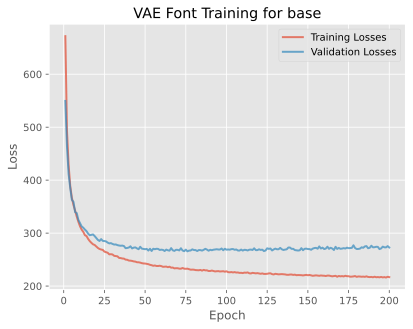

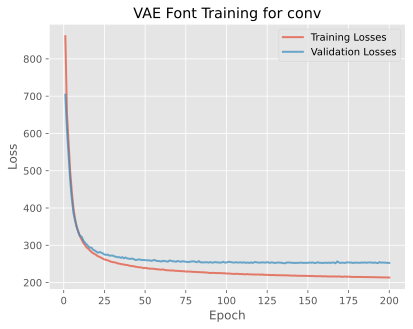

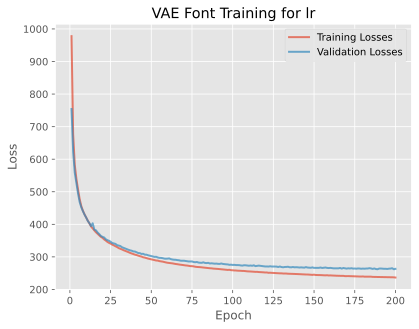

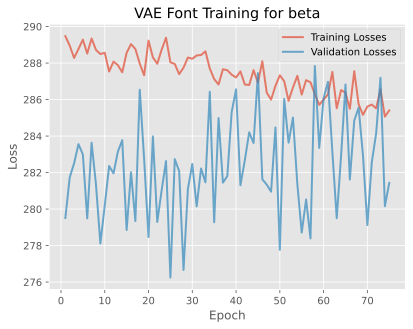

In [ ]:
for experiment in ['base', 'conv', 'lr', 'beta']:
    train_losses=np.loadtxt(f'{results_path}/models/{experiment}/training_losses.txt')
    val_losses=np.loadtxt(f'{results_path}/models/{experiment}/validation_losses.txt')
    plt.plot(
        range(1,len(train_losses)+1),
        train_losses,
        label='Training Losses',
        linewidth=2,
        alpha=0.7
    )
    plt.plot(
        range(1,len(val_losses)+1),
        val_losses,
        label='Validation Losses',
        linewidth=2,
        alpha=0.7
    )

    plt.title(f'VAE Font Training for {experiment}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Através da análise dos plots, podemos perceber que o modelo base foi o que mais sofreu overfitting, visto que a loss de validação está muito acima da de treino. Ao adotarmos camadas convolucionais e diminuirmos a learning rate, notamos o decremento do overfitting observado no modelo base. Por fim, a regularização BetaVAE foi capaz de impedir o crescimento da loss de validação, interrompendo o algoritmo após um intervalo de tempo.

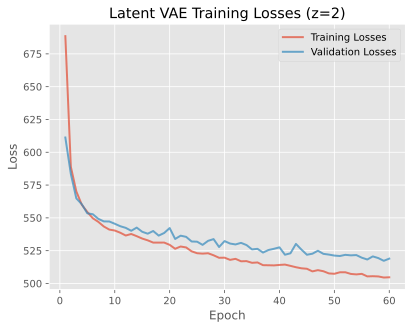

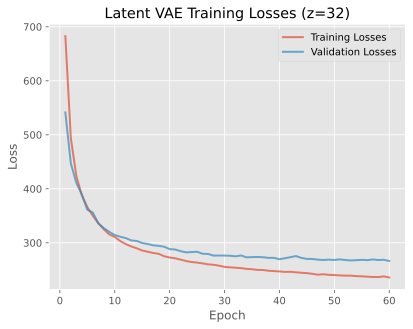

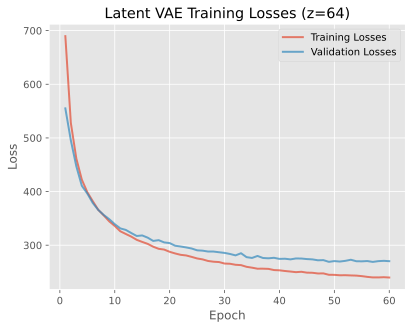

In [ ]:
latent_losses = {}
for z in [2, 32, 64]:
    model_name = f'z{z}'
    latent_losses[model_name] = {
        'train': np.loadtxt(f'{results_path}/models/latent/{model_name}/training_losses.txt'),
        'val': np.loadtxt(f'{results_path}/models/latent/{model_name}/validation_losses.txt')
    }

    plt.figure()
    plt.plot(range(1, len(latent_losses[model_name]['train']) + 1), latent_losses[model_name]['train'], label='Training Losses', linewidth=2, alpha=0.7)
    plt.plot(range(1, len(latent_losses[model_name]['val']) + 1), latent_losses[model_name]['val'], label='Validation Losses', linewidth=2, alpha=0.7)
    plt.title(f'Latent VAE Training Losses (z={z})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Não se nota diferença significativa entre as curvas de cada experimento com dimensão latente.

## Análises qualitativas

### Geração a partir do decoder

In [ ]:
def generate_samples(model, device, num_samples):
    model.eval()
    with torch.no_grad():
        sample = torch.randn(num_samples, model.z).to(device)
        generated_images = model.decode(sample).cpu()
    return generated_images

def plot_generated_samples(samples, title):
    samples = samples.view(-1, 50, 50)
    num_samples = len(samples)
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    fig.suptitle(title)

    if num_samples == 1:
        axes.imshow(samples[0].squeeze(), cmap='gray')
        axes.axis('off')
    else:
        for i, ax in enumerate(axes):
            ax.imshow(samples[i].squeeze(), cmap='gray')
            ax.axis('off')
    plt.show()

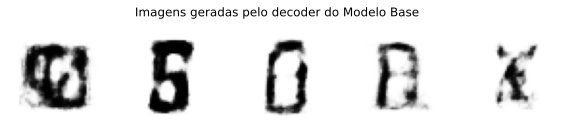

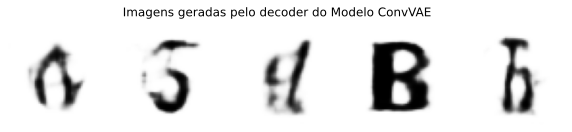

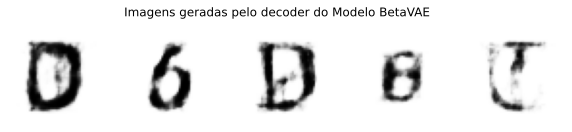

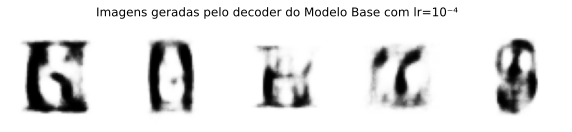

In [ ]:
base_generated = generate_samples(base_model, device, 5)
conv_generated = generate_samples(conv_model, device, 5)
beta_generated = generate_samples(beta_model, device, 5)
lr_generated = generate_samples(lr_model, device, 5)

plot_generated_samples(base_generated, "Imagens geradas pelo decoder do Modelo Base")
plot_generated_samples(conv_generated, "Imagens geradas pelo decoder do Modelo ConvVAE")
plot_generated_samples(beta_generated, "Imagens geradas pelo decoder do Modelo BetaVAE")
plot_generated_samples(lr_generated, "Imagens geradas pelo decoder do Modelo Base com lr=10⁻⁴")

É possivel observar que os decoders de cada modelo tiveram dificuldade em gerar imagens a partir de ruído. Entre outros fatores, evidencia-se o uso de apenas 200 épocas para o treinamento de cada modelo. Para um experimento futuro, recomenda-se fortemente o uso de 300 épocas ou mais, além de um conjunto maior de dados.

Porém, podemos perceber que a ConvVAE foi a que obteve melhores resultados perceptuais, com alguns grifos bem legíveis e distinguíveis.

### Reconstrução a partir da entrada

Comparação entre as imagens originais (em cima) e as geradas pela VAE (em baixo) após 200 épocas (exceto BetaVAE, por causa do early-stop, e experimentos com espaço latente).

- **Modelo Base**

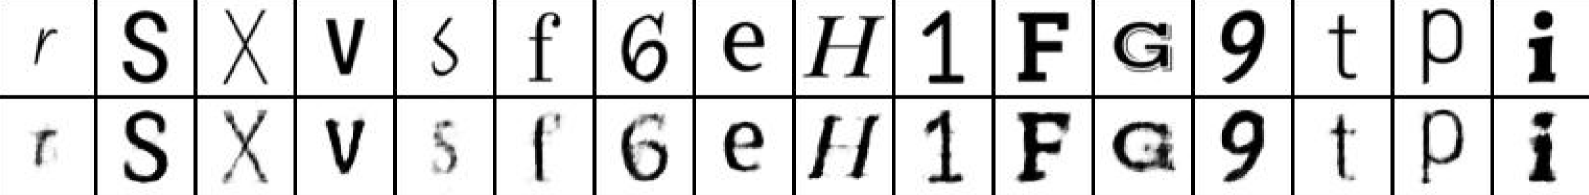

- **ConvVAE**

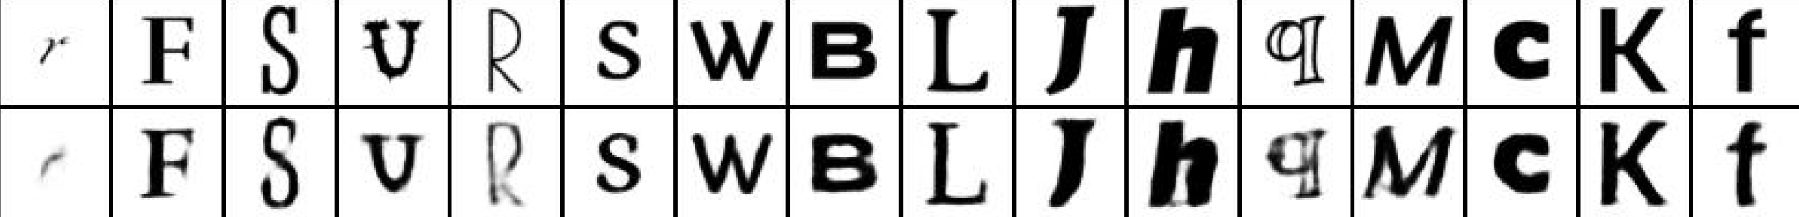

- **BetaVAE** (parou em 75 épocas)

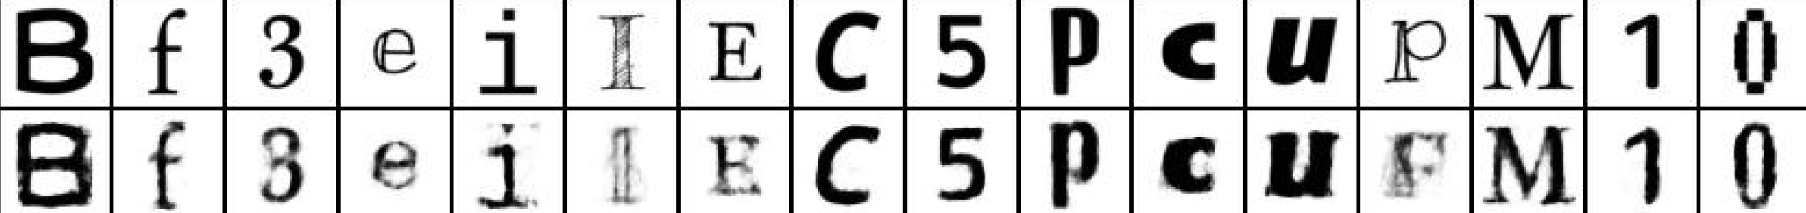

- **Learning Rate Modificada**

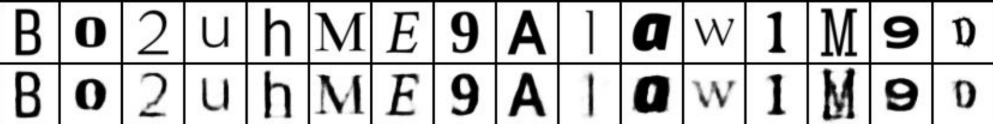

- **Espaço Latente z = 2** (60 épocas)

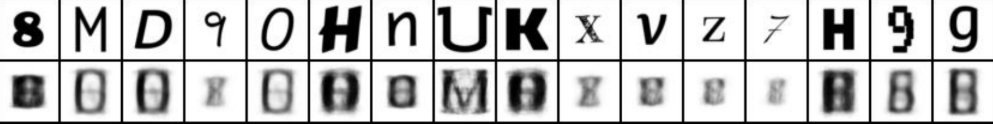

- **Espaço Latente z = 32** (60 épocas)

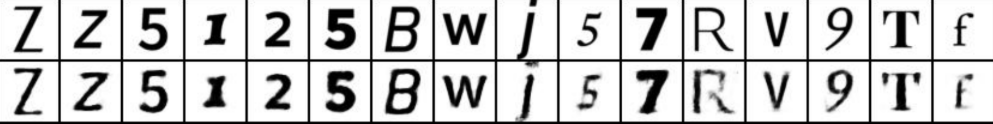

- **Espaço Latente z = 64** (60 épocas)

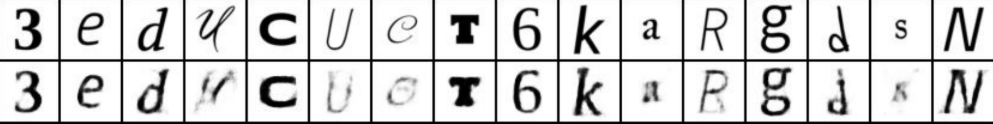

Entre todos os modelos, apenas o experimento com z = 2 não obteve desempenho aceitável na tarefa de reconstrução da imagem de entrada. Os experimentos que não envolviam alteração da dimensão latente tiveram desempenho similar, com ligeira prevalência da ConvVAE.

## Análises quantitativas

### Criação de dataloader teste

Com base em pastas não utilizadas para treino (foram utilizadas 5% das restantes).

In [ ]:
!rm -rf /content/data/testFonts/
!mkdir /content/data/testFonts/

In [ ]:
test_path = '/content/data/testFonts'

all_folders = os.listdir(path)
train_val_folders = os.listdir(train_path)

remaining_folders = [folder for folder in all_folders if folder not in train_val_folders]

num_test_folders = int(len(remaining_folders) * 0.05)
test_folders = random.sample(remaining_folders, num_test_folders)

print(f"Number of test folders: {len(test_folders)}")

for folder in tqdm(test_folders):
    os.mkdir(f'{test_path}/{folder}')
    images = os.listdir(f'{path}/{folder}')
    for image in images:
        shutil.copy(f'{path}/{folder}/{image}',
                  f'{test_path}/{folder}/{image}')

test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(f'{test_path}',transform=transforms_set),
    batch_size=batch_size, shuffle=True
)

print(f"Number of batches in test loader: {len(test_loader)}")

Number of test folders: 49


  0%|          | 0/49 [00:00<?, ?it/s]

Number of batches in test loader: 48


### Erro de Reconstrução

In [ ]:
def evaluate_reconstruction(model, device, test_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            if isinstance(model, ConvVAE):
                loss = ConvVAE_loss_function(recon_batch, data, mu, logvar)
            else:
                loss = loss_function(recon_batch, data, mu, logvar)
            total_loss += loss.item()

    return total_loss / len(test_loader.dataset)

In [ ]:
test_loss_base = evaluate_reconstruction(base_model, device, test_loader)
test_loss_conv = evaluate_reconstruction(conv_model, device, test_loader)
test_loss_beta = evaluate_reconstruction(beta_model, device, test_loader)
test_loss_lr = evaluate_reconstruction(lr_model, device, test_loader)

print(f'Reconstruction loss on test set for Base VAE: {test_loss_base:.4f}')
print(f'Reconstruction loss on test set for Conv VAE: {test_loss_conv:.4f}')
print(f'Reconstruction loss on test set for Beta VAE: {test_loss_beta:.4f}')
print(f'Reconstruction loss on test set for LR VAE: {test_loss_lr:.4f}')
print("\nReconstruction loss for Latent Space Experiments:")

for z in [2, 32, 64]:
    model_name = f'z{z}'
    test_loss_latent = evaluate_reconstruction(latent_models[model_name], device, test_loader)
    print(f'  z={z}: {test_loss_latent:.4f}')

Reconstruction loss on test set for Base VAE: 300.8943
Reconstruction loss on test set for Conv VAE: 276.4374
Reconstruction loss on test set for Beta VAE: 309.1537
Reconstruction loss on test set for LR VAE: 283.2077

Reconstruction loss for Latent Space Experiments:
  z=2: 545.8814
  z=32: 288.3547
  z=64: 293.1365


Analizando as losses de reconstrução, percebemos que a ConvVAE foi o modelo com melhor performance, seguido do modelo com menor lr. No entanto, a BetaVAE obteve menor desempenho do que o modelo base, resultado direto da regularização aplicada.

Entre as losses dos experimentos com espaço latente, apenas o modelo com z = 2 teve desempenho pior que a base, enquanto os outros dois ficaram com performance parecida.

### MSE e SSIM

In [ ]:
def calculate_quality_metrics(model, device, test_loader):
    model.eval()
    mse_values = []
    ssim_values = []

    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(tqdm(test_loader, desc="Calculating quality metrics")):
            data = data.to(device)
            recon_batch, _, _ = model(data)

            if isinstance(model, VAE):
                recon_batch = recon_batch.view(recon_batch.size(0), 1, 50, 50)
            elif isinstance(model, ConvVAE) and recon_batch.shape != data.shape:
                recon_batch = F.interpolate(recon_batch, size=data.shape[2:], mode='bilinear', align_corners=False)

            orig_np = data.cpu().numpy()
            recon_np = recon_batch.cpu().numpy()

            if orig_np.ndim == 4:
                orig_np = orig_np.squeeze(1)
            if recon_np.ndim == 4:
                recon_np = recon_np.squeeze(1)

            for i in range(len(orig_np)):
                orig_img = orig_np[i]
                recon_img = recon_np[i]

                if orig_img.ndim > 2:
                    orig_img = orig_img.squeeze()
                if recon_img.ndim > 2:
                    recon_img = recon_img.squeeze()

                # MSE
                mse = np.mean((orig_img - recon_img) ** 2)
                mse_values.append(mse)

                # SSIM
                if orig_img.ndim == 2 and recon_img.ndim == 2:
                    try:
                        ssim_val = ssim(orig_img, recon_img, data_range=1.0)
                        ssim_values.append(ssim_val)
                    except Exception as e:
                        print(f"SSIM calculation error: {e}")
                        ssim_values.append(0)

    return np.mean(mse_values), np.mean(ssim_values)

In [ ]:
print("Calculating Reconstruction Quality Metrics (MSE and SSIM)...")

mse_base, ssim_base = calculate_quality_metrics(base_model, device, test_loader)
print(f'Base VAE - MSE: {mse_base:.4f}, SSIM: {ssim_base:.4f}')

mse_conv, ssim_conv = calculate_quality_metrics(conv_model, device, test_loader)
print(f'Conv VAE - MSE: {mse_conv:.4f}, SSIM: {ssim_conv:.4f}')

mse_beta, ssim_beta = calculate_quality_metrics(beta_model, device, test_loader)
print(f'Beta VAE - MSE: {mse_beta:.4f}, SSIM: {ssim_beta:.4f}')

mse_lr, ssim_lr = calculate_quality_metrics(lr_model, device, test_loader)
print(f'LR VAE - MSE: {mse_lr:.4f}, SSIM: {ssim_lr:.4f}')


print("\nReconstruction Quality Metrics for Latent Space Experiments:")
for z in [2, 32, 64]:
    model_name = f'z{z}'
    mse_latent, ssim_latent = calculate_quality_metrics(latent_models[model_name], device, test_loader)
    print(f'  z={z}: MSE: {mse_latent:.4f}, SSIM: {ssim_latent:.4f}')

Calculating Reconstruction Quality Metrics (MSE and SSIM)...


Calculating quality metrics:   0%|          | 0/48 [00:00<?, ?it/s]

Base VAE - MSE: 0.0115, SSIM: 0.8846


Calculating quality metrics:   0%|          | 0/48 [00:00<?, ?it/s]

Conv VAE - MSE: 0.0103, SSIM: 0.9039


Calculating quality metrics:   0%|          | 0/48 [00:00<?, ?it/s]

Beta VAE - MSE: 0.0146, SSIM: 0.8496


Calculating quality metrics:   0%|          | 0/48 [00:00<?, ?it/s]

LR VAE - MSE: 0.0107, SSIM: 0.8858

Reconstruction Quality Metrics for Latent Space Experiments:


Calculating quality metrics:   0%|          | 0/48 [00:00<?, ?it/s]

  z=2: MSE: 0.0506, SSIM: 0.5737


Calculating quality metrics:   0%|          | 0/48 [00:00<?, ?it/s]

  z=32: MSE: 0.0113, SSIM: 0.8780


Calculating quality metrics:   0%|          | 0/48 [00:00<?, ?it/s]

  z=64: MSE: 0.0122, SSIM: 0.8721


Analisando o MSE, novamente a ConvVAE e o modelo com menor lr destacaram-se, enquanto a BetaVAE obteve menor desempenho do que o modelo base. Comparando os MSEs dos experimentos com espaço latente, apenas o modelo com z = 2 teve desempenho pior que a base, enquanto os outros dois ficaram com performance parecida.

Agora analisando o SSIM, que mede a similaridade entre a entrada e a reconstrução considerando luminância, contraste e estrutura, apenas a ConvVAE obteve um outperform em relação ao modelo base. É interessante perceber que a alteração da lr não impactou significativamente a qualidade perceptual da imagem. Novamente, a BetaVAE e o modelo com z = 2 tiveram os piores resultados.



### Construção do Espaço Latente e Comparação com PCA

O espaço latente é construído de forma diferente de um autoencoder tradicional. Em vez de o codificador produzir um único ponto no espaço latente para cada entrada, ele produz parâmetros (média e log-variância) de uma distribuição de probabilidade (geralmente Gaussiana) no espaço latente.


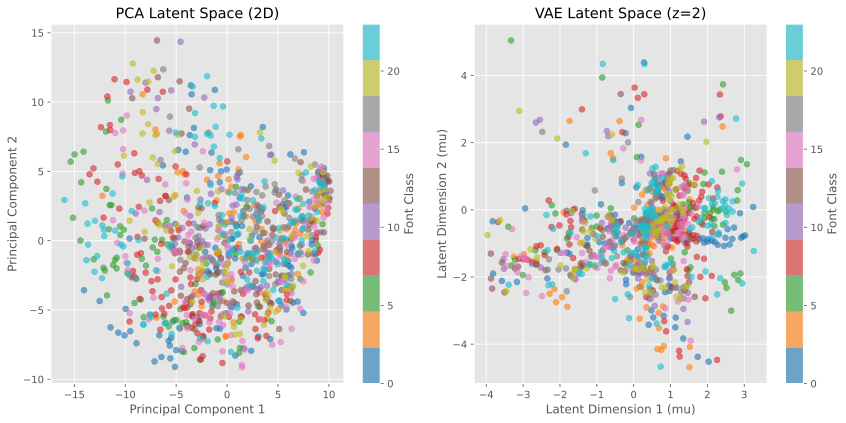

In [ ]:
subset_size = 1000 # subset para visualização

train_dataset_all = datasets.ImageFolder(f'{train_path}', transform=transforms_set)
train_loader_all = DataLoader(train_dataset_all, batch_size=subset_size, shuffle=False)

data_subset, labels_subset = next(iter(train_loader_all))
data_subset_flat = data_subset.view(data_subset.size(0), -1).cpu().numpy()
pca = PCA(n_components=2)
pca_latent_space = pca.fit_transform(data_subset_flat)

with torch.no_grad():
    data_subset_gpu = data_subset.to(device)
    mu_vae, logvar_vae = latent_models['z2'].encode(data_subset_gpu.view(data_subset_gpu.size(0), -1))
    vae_latent_space = mu_vae.cpu().numpy()


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(pca_latent_space[:, 0], pca_latent_space[:, 1], c=labels_subset.numpy(), cmap='tab10', alpha=0.6)
plt.title('PCA Latent Space (2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Font Class')

plt.subplot(1, 2, 2)
plt.scatter(vae_latent_space[:, 0], vae_latent_space[:, 1], c=labels_subset.numpy(), cmap='tab10', alpha=0.6)
plt.title('VAE Latent Space (z=2)')
plt.xlabel('Latent Dimension 1 (mu)')
plt.ylabel('Latent Dimension 2 (mu)')
plt.colorbar(label='Font Class')

plt.tight_layout()
plt.show()


À esquerda, temos o PCA do conjunto de pontos amostrado, enquanto que a direita é apresentado o espaço latente do VAE com z = 2. Podemos perceber que, embora ambos realizem a redução da dimensionalidade da mesma entrada, eles não geram representações idênticas.

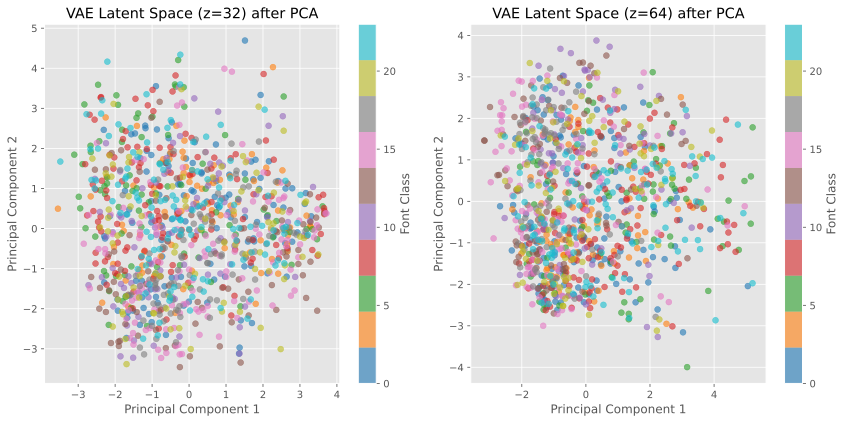

In [ ]:
with torch.no_grad():
    data_subset_gpu = data_subset.to(device)

    mu_vae_z32, logvar_vae_z32 = latent_models['z32'].encode(data_subset_gpu.view(data_subset_gpu.size(0), -1))
    vae_latent_space_z32 = mu_vae_z32.cpu().numpy()

    mu_vae_z64, logvar_vae_z64 = latent_models['z64'].encode(data_subset_gpu.view(data_subset_gpu.size(0), -1))
    vae_latent_space_z64 = mu_vae_z64.cpu().numpy()


pca_z32 = PCA(n_components=2)
vae_latent_space_z32_pca = pca_z32.fit_transform(vae_latent_space_z32)

pca_z64 = PCA(n_components=2)
vae_latent_space_z64_pca = pca_z64.fit_transform(vae_latent_space_z64)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(vae_latent_space_z32_pca[:, 0], vae_latent_space_z32_pca[:, 1], c=labels_subset.numpy(), cmap='tab10', alpha=0.6)
plt.title('VAE Latent Space (z=32) after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Font Class')

plt.subplot(1, 2, 2)
plt.scatter(vae_latent_space_z64_pca[:, 0], vae_latent_space_z64_pca[:, 1], c=labels_subset.numpy(), cmap='tab10', alpha=0.6)
plt.title('VAE Latent Space (z=64) after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Font Class')

plt.tight_layout()
plt.show()

Neste exemplo, podemos observar o PCA aplicado diretamente a dimensão latente das VAEs com dimensões z = 32 e z = 64, possibilitando visualização inteligível. Nota-se que não há qualquer forma de agrupamento de classes na distribuição dos dados, indicando que a representação latente da VAE não é linear, já que o PCA apenas revela clusters para dados lineares.

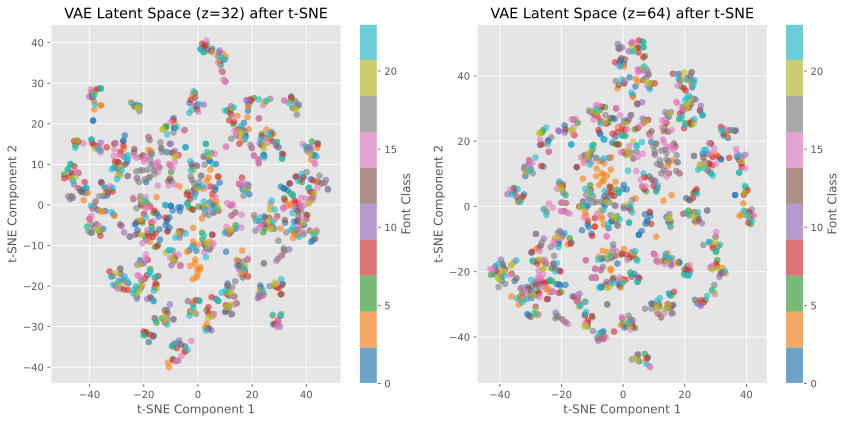

In [ ]:
# Perform t-SNE for z=32 latent space
tsne_z32 = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
vae_latent_space_z32_tsne = tsne_z32.fit_transform(vae_latent_space_z32)

# Perform t-SNE for z=64 latent space
tsne_z64 = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
vae_latent_space_z64_tsne = tsne_z64.fit_transform(vae_latent_space_z64)

# Plot the 2D t-SNE results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(vae_latent_space_z32_tsne[:, 0], vae_latent_space_z32_tsne[:, 1], c=labels_subset.numpy(), cmap='tab10', alpha=0.6)
plt.title('VAE Latent Space (z=32) after t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Font Class')

plt.subplot(1, 2, 2)
plt.scatter(vae_latent_space_z64_tsne[:, 0], vae_latent_space_z64_tsne[:, 1], c=labels_subset.numpy(), cmap='tab10', alpha=0.6)
plt.title('VAE Latent Space (z=64) after t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Font Class')

plt.tight_layout()
plt.show()

Fazendo o mesmo experimento, mas agora adotando o T-SNE (método não-linear de redução de dimensionalidade) na dimensão latente de cada modelo, percebemos nitidamente a formação de clusters, provavelmente indicando grifos similares. Sendo assim, evidencia-se que a distribuição dos dados no espaço latente é não-linear.

# Conclusão

Entre todos os modelos propostos, a ConvVAE obteve desempenho superior em todas as métricas avaliadas, evidenciando o poder de adicionar camadas convolucionais à DGMs para geração de imagens. Também foi notável o efeito da diminuição da lr.

Para um experimento futuro, sugere-se combinar a abordagem das camadas convolucionais juntamente com a diminuição da lr, obtendo possivelmente desempenho superior.

A principal limitação dos experimento consiste no treinamento com menos épocas, o que pode ter contribuído para alguns dos resultados negativos destacados anteriormente. Sendo assim, sugere-se também o treinamento com mais épocas (300 ou mais).